<a href="https://colab.research.google.com/github/cty20010831/SOCI-40133-Computational-Content-Analysis/blob/main/week%205/5-Classifying-Meanings-and-Documents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [2]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/MACS_60000_Computational Content Analysis')

In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-wmhrn674
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-wmhrn674
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done


# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [5]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [6]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [7]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [8]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [9]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


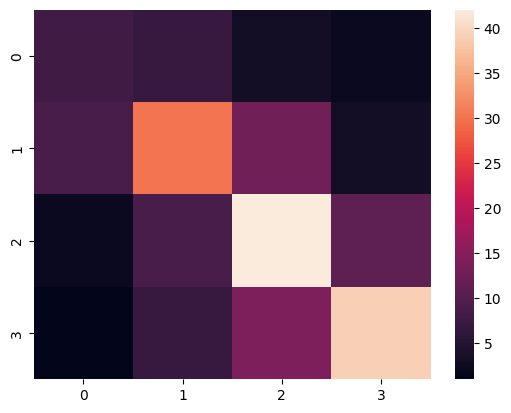

In [10]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [11]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [12]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [13]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [14]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [15]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


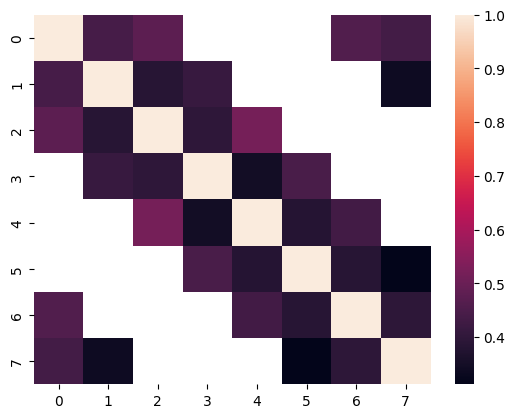

In [16]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [17]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [18]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [19]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

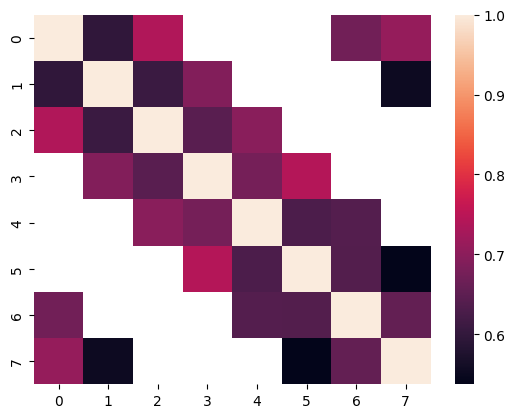

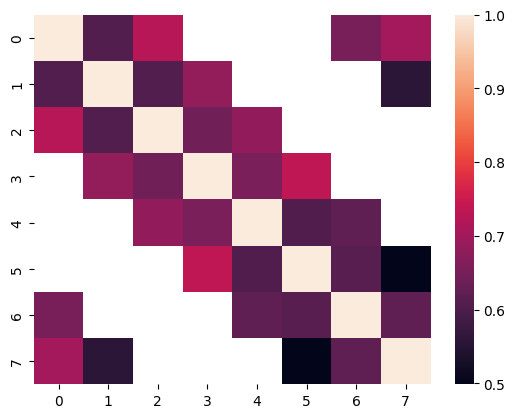

In [20]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [21]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [22]:
# Here I have 3 people do the content annotation (and there is no missing values)
x_new = np.loadtxt('sample_annotate_numerical.txt')
anno_new = AnnotationsContainer.from_array(x_new)

Interrogate the AnnotationsContainer object.

In [23]:
anno_new.annotations

array([[0, 1, 2],
       [0, 2, 2],
       [2, 2, 3],
       [3, 3, 3],
       [2, 1, 2],
       [1, 1, 0],
       [1, 1, 0],
       [2, 3, 0],
       [3, 3, 1],
       [3, 3, 3],
       [2, 2, 2],
       [1, 2, 3],
       [3, 2, 2],
       [3, 1, 1],
       [0, 0, 0],
       [1, 1, 1],
       [2, 1, 2],
       [1, 2, 3],
       [3, 2, 2],
       [3, 1, 1]])

In [24]:
anno_new.labels

[0.0, 1.0, 2.0, 3.0]

Calculate annotation statistics:

In [25]:
pyanno.measures.agreement.labels_frequency(anno_new.annotations,4)

array([0.13333333, 0.28333333, 0.31666667, 0.26666667])

"Confusion matrix" or matrix of coded agreements between any two coders:

[[1. 1. 1. 0.]
 [0. 3. 2. 0.]
 [0. 2. 2. 1.]
 [0. 2. 2. 3.]]


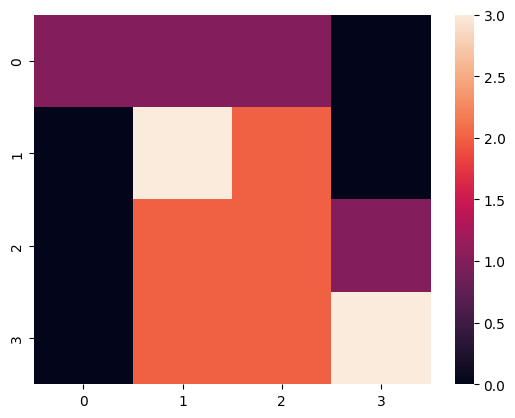

In [26]:
c = pyanno.measures.agreement.confusion_matrix(anno_new.annotations[:,0], anno_new.annotations[:,1], 4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [27]:
# Calculate Scott's pi
scotts_pi(anno_new.annotations[:,0], anno_new.annotations[:,1])

0.23478260869565226

In [28]:
# Calculate Fleiss' kappa
fleiss_kappa(anno_new.annotations[::])

0.22433460076045622

In [29]:
# Calculate Krippendorff's alpha
krippendorffs_alpha(anno_new.annotations[::])

0.3627803932428689

In [30]:
# Calculate cohen's alpha
m = pairwise_matrix(cohens_kappa, anno_new.annotations)
print(m)

[[1.         0.25170068 0.12751678]
 [0.25170068 1.         0.3220339 ]
 [0.12751678 0.3220339  1.        ]]


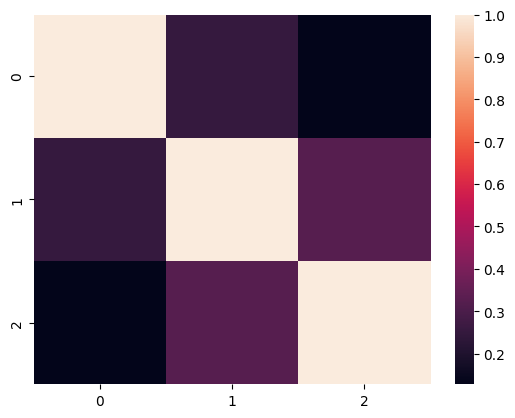

In [31]:
ax = seaborn.heatmap(m)
plt.show()

In [32]:
# Calculate the average Cohen's kappa for all pairs of coders that have coded against one another
pairwise_metric_average(cohens_kappa, anno_new.annotations)

0.2337504523668945

In [33]:
# Calculate the average weighted kappa for all pairs of coders that have coded against one another
pairwise_metric_average(cohens_weighted_kappa, anno_new.annotations)

0.28956699543243053

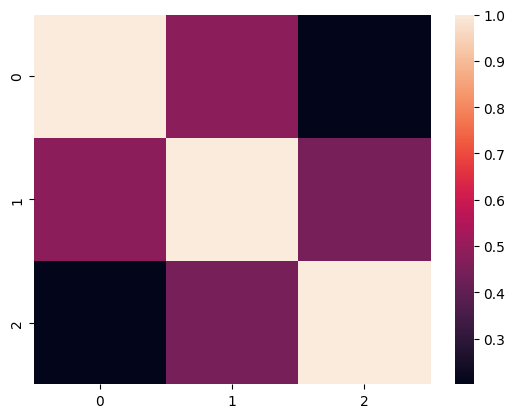

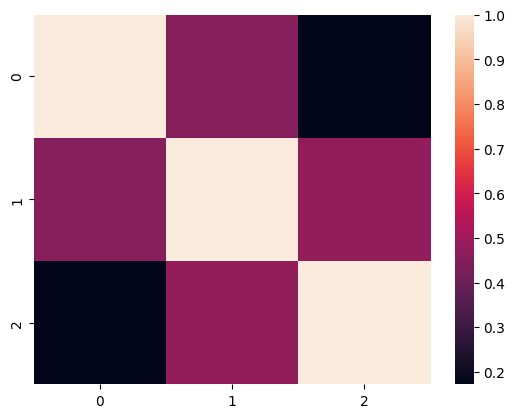

In [34]:
# Assess the correlation of values (Pearson's rho) and correlation of ranks (Spearman's rho) for pairs of coders:
n = pairwise_matrix(pearsons_rho, anno_new.annotations)
m = pairwise_matrix(spearmans_rho, anno_new.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

In [35]:
# Averaged Pearson's and Spearman's rhos over all comparable pairs:
print(pairwise_metric_average(pearsons_rho, anno_new.annotations), pairwise_metric_average(spearmans_rho, anno_new.annotations))

0.3758091304770303 0.36740212194743144


**Discussion**:

For the content in my domain, there is extremely high variability and therefore low reliability of human assessments, presumably due to the fact that there could be high "degree of freedom" for subjective judement.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [36]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [37]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [38]:
dfTrain

,vect,category
551,"[-0.8241390052125017, -0.031730397741380374]",1
184,"[-0.06923923833109702, 0.019169761303613243]",0
279,"[-0.5519619491190481, 0.7734516218883282]",1
412,"[0.2416427465388358, 0.13270952752599124]",0
606,"[-0.10019590283020177, 0.027810350083733015]",0
...,...,...
584,"[0.3829171404358614, 0.02688274843868038]",0
45,"[0.05758639073548099, 0.3100329847514895]",1
563,"[-0.5233574098938175, -0.7048482380566635]",1
874,"[-0.1400777589425176, 0.10442019815046452]",0


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [39]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


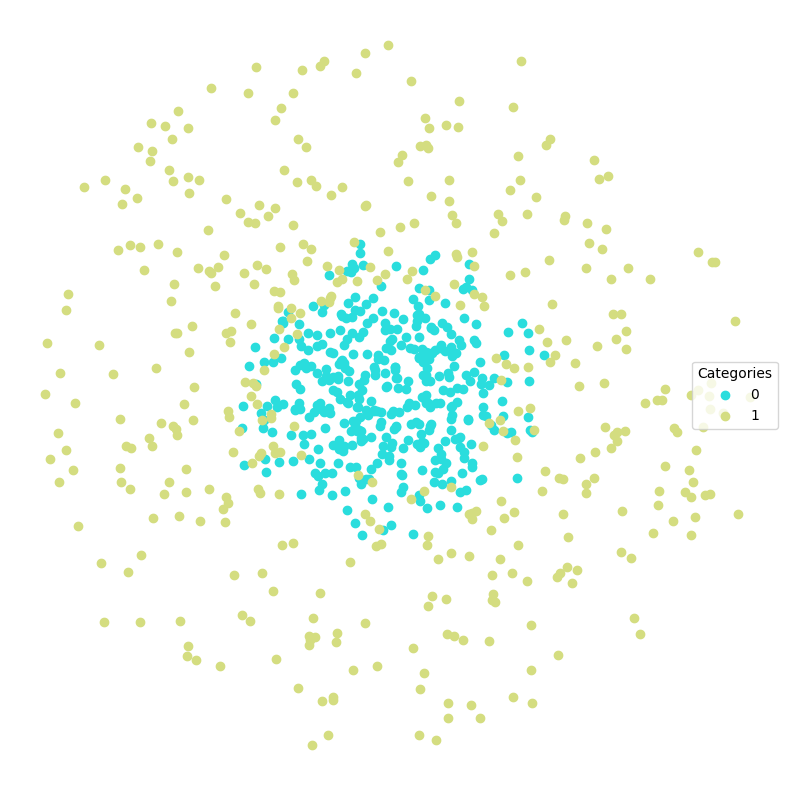

In [40]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [41]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [42]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'random',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [43]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [44]:
dfTrain['vect']

551    [-0.8241390052125017, -0.031730397741380374]
184    [-0.06923923833109702, 0.019169761303613243]
279       [-0.5519619491190481, 0.7734516218883282]
412       [0.2416427465388358, 0.13270952752599124]
606    [-0.10019590283020177, 0.027810350083733015]
                           ...                     
584       [0.3829171404358614, 0.02688274843868038]
45        [0.05758639073548099, 0.3100329847514895]
563      [-0.5233574098938175, -0.7048482380566635]
874      [-0.1400777589425176, 0.10442019815046452]
384       [0.08469452759739114, 0.1927277966282416]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [45]:
np.stack(dfTrain['vect'])

array([[-0.82413901, -0.0317304 ],
       [-0.06923924,  0.01916976],
       [-0.55196195,  0.77345162],
       ...,
       [-0.52335741, -0.70484824],
       [-0.14007776,  0.1044202 ],
       [ 0.08469453,  0.1927278 ]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [46]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.125,0.869572,0.864407,0.83932,0.918919
1,0.125,0.869572,0.890244,0.81020,0.820225


This lets us look at which classes do better:

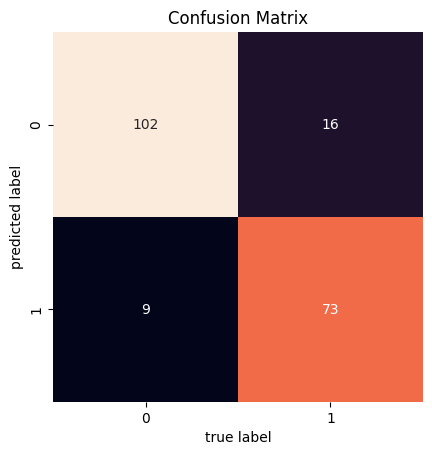

In [47]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

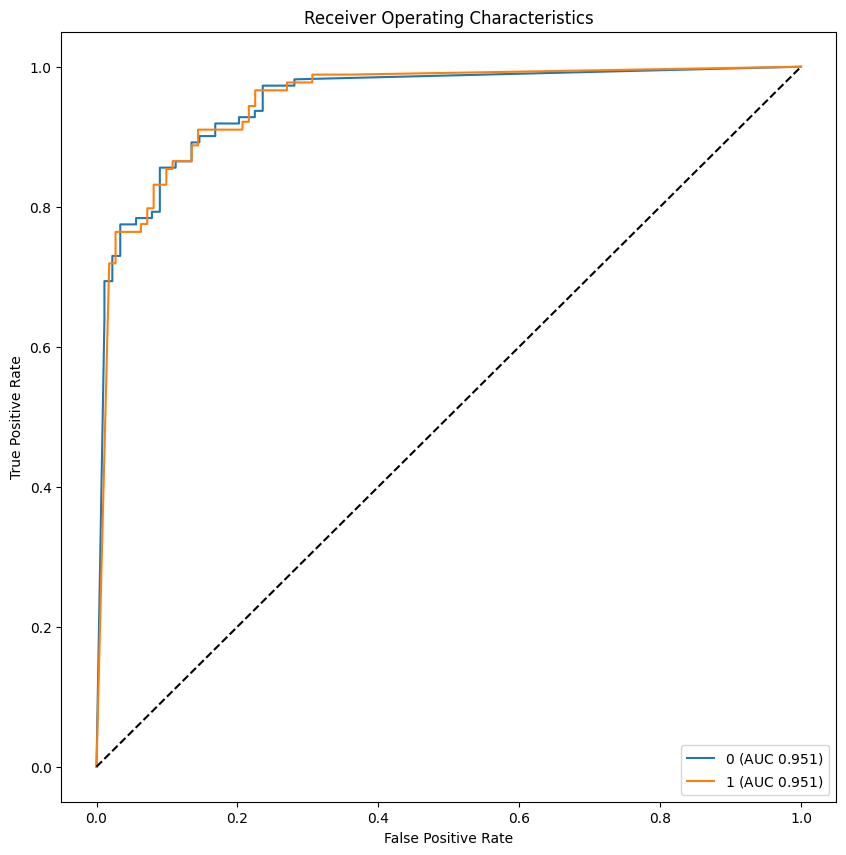

In [48]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


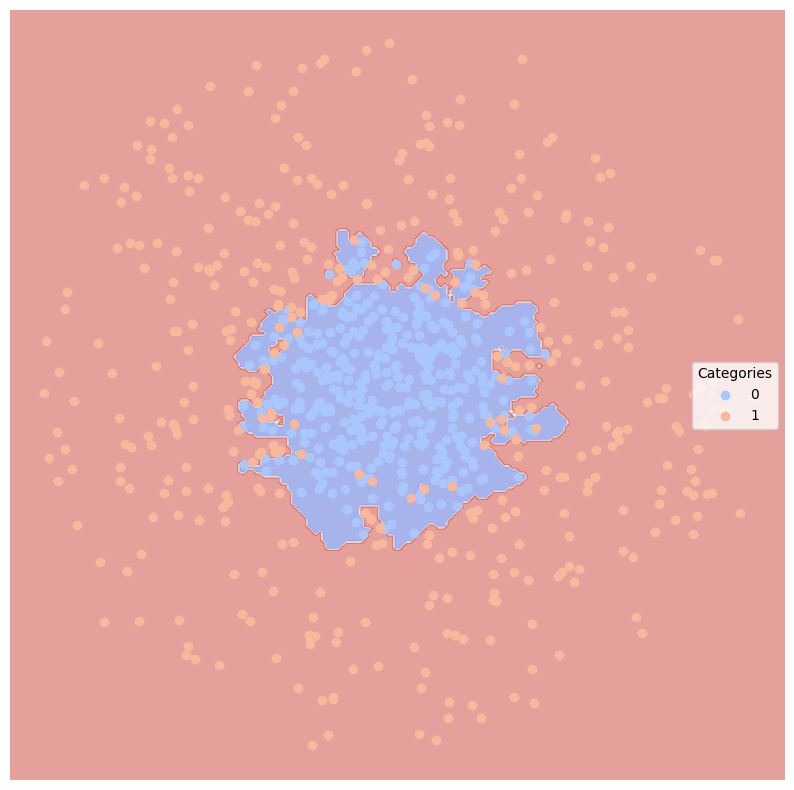

In [49]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [50]:
redditDf = pandas.read_csv('reddit.csv')
redditDf = redditDf.dropna()
redditDf['category'] = [s.split(':')[0] for s in redditDf['subreddit']]

In [51]:
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.generateVecs(redditDf), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [52]:
dfTrain

,Unnamed: 0,author,over_18,score,subreddit,text,title,url,category,tokenized_text,normalized_text,vect
1241,1241,throwawayandpanic,False,4320,Relationships,"original post is here, https://www.reddit.com/...",UPDATE: My(25) BF(28) won't ask for my hand in...,https://www.reddit.com/r/relationships/comment...,Relationships,"[original, post, is, here, https://www.reddit....","[original, post, https://www.reddit.com/r/rela...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
174,174,harplaw,False,3614,Tales From Tech Support,9 years ago I was neck deep in a project when ...,Backups Pay Off,https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[9, years, ago, I, was, neck, deep, in, a, pro...","[year, ago, neck, deep, project, frantic, cust...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
346,346,TheDroolinFool,False,2732,Tales From Tech Support,Here's another call from this week taken on th...,"""Let me just put my husband on who knows about...",https://www.reddit.com/r/talesfromtechsupport/...,Tales From Tech Support,"[Here, 's, another, call, from, this, week, ta...","[week, take, hour, hell, desk, service, desk, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1231,1231,Throwawaynewbfhelp,False,4636,Relationships,Original post: https://m.reddit.com/r/relation...,My [56 M] daughter [18 F] has a new 29 year ol...,https://www.reddit.com/r/relationships/comment...,Relationships,"[Original, post, https://m.reddit.com/r/relati...","[original, post, https://m.reddit.com/r/relati...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1082,1082,deer-intern,False,124,Weeaboo Tales: stories about the extreme fans ...,"The title is a bit misleading, as I wasn't rai...",Growing Up with a Weeaboo,https://www.reddit.com/r/weeabootales/comments...,Weeaboo Tales,"[The, title, is, a, bit, misleading, as, I, wa...","[title, bit, misleading, raise, alongside, wee...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1384,1384,hurtneedhelp,False,2750,Relationships,UPDATE to [this](https://www.reddit.com/r/rela...,UPDATE: My [23F] boyfriend [28M] of 8 years sa...,https://www.reddit.com/r/relationships/comment...,Relationships,"[UPDATE, to, this](https://www.reddit.com, r, ...","[update, this](https://www.reddit.com, r, rela...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
588,588,NotMuchOfAGirlfriend,False,43,Bad Roommates: Tales of Irritation,I was fresh out of high school when I made one...,"My Little, White box",https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[I, was, fresh, out, of, high, school, when, I...","[fresh, high, school, bad, decision, life, exp...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
750,750,girlpearl,False,31,Bad Roommates: Tales of Irritation,Hey guys 21F here. So I know which women in m...,"Vaginal crumbs & much more, advice please",https://www.reddit.com/r/badroommates/comments...,Bad Roommates,"[Hey, guys, 21F, here, So, I, know, which, wom...","[hey, guy, 21f, know, woman, apartment, leave,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1387,1387,Hairthrowawayx2,False,2736,Relationships,She has been my sister-in-law for a year and w...,Got into a verbal argument with my (30F) SIL (...,https://www.reddit.com/r/relationships/comment...,Relationships,"[She, has, been, my, sister, in, law, for, a, ...","[sister, law, year, get, rude, condescend, hus...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [53]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [54]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [55]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates,0.02500,0.975200,0.930233,0.913794,0.975610
Tales From Tech Support,0.01250,0.987551,0.963855,0.955081,0.987654
Weeaboo Tales,0.00625,0.990456,0.984848,0.973052,0.984848
Relationships,0.03125,0.951677,0.976471,0.915627,0.912088


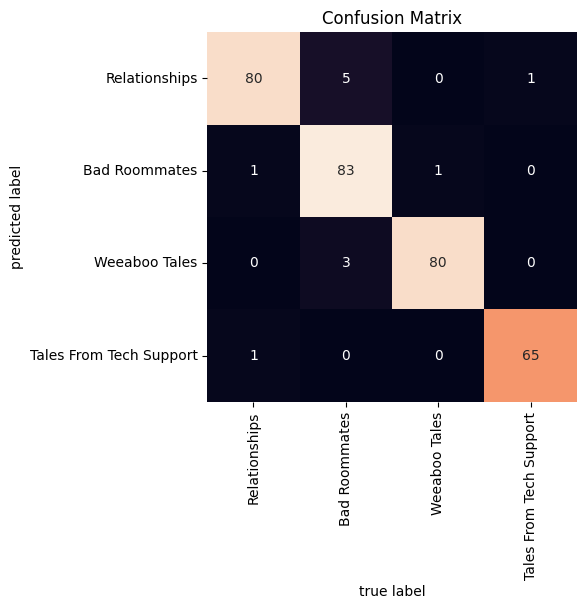

In [56]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

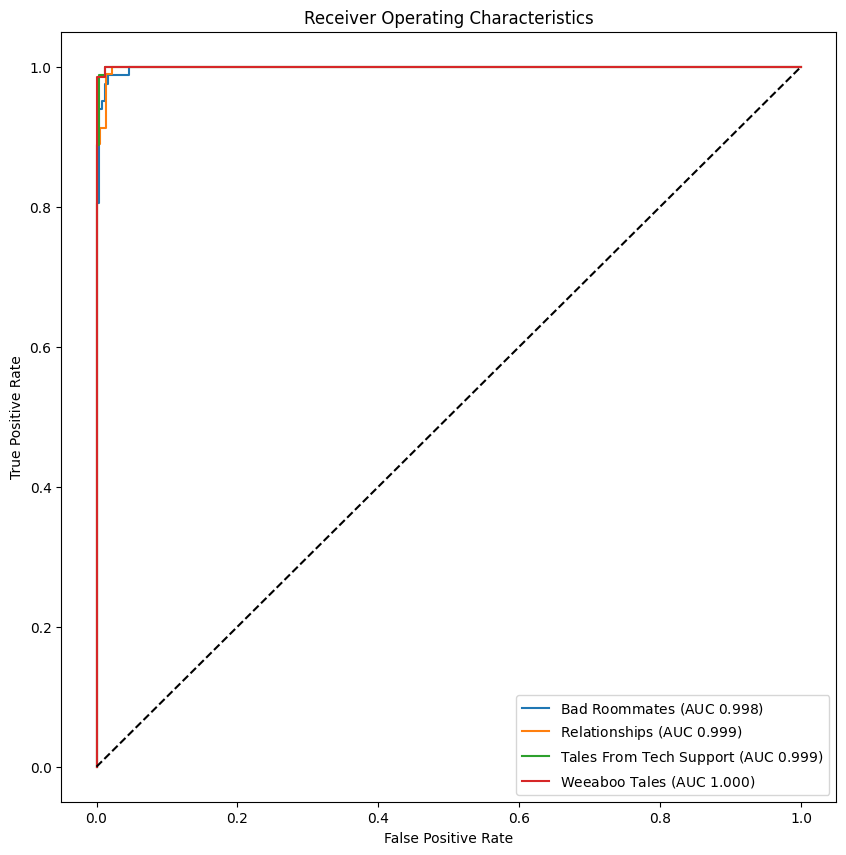

In [57]:
lucem_illud.plotMultiROC(clf, dfTest)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


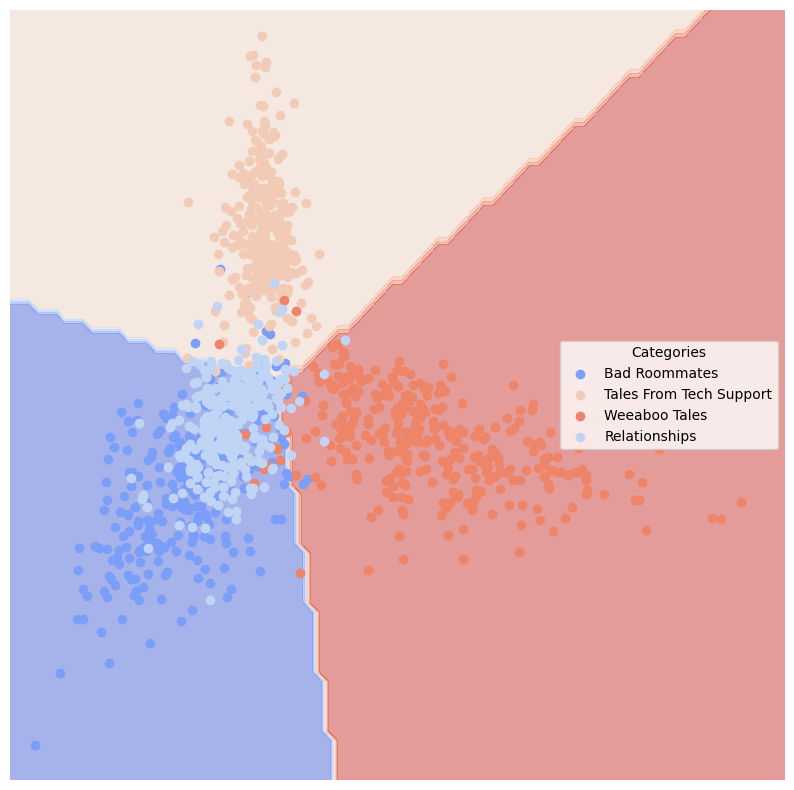

In [58]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

For this exercise, I will use `sklearn.datasets.make_classification` to generate synthetic datasets.

In [59]:
# Modify the original evaluateClassifier function to fit my purpose
def evaluateClassifier_updated(clf, X_test, y_test):
    predictions = clf.predict(X_test)
    classes = []
    results = {
        'Error_Rate' : [],
        'AUC' : [],
        'Precision' : [],
        'Average_Precision' : [],
        'Recall' : [],
        }

    for cat in set(y_test):
        preds = [True if (c == cat) else False for c in predictions]
        acts = [True if (c == cat) else False for c in y_test]
        classes.append(cat)
        results['AUC'].append(sklearn.metrics.roc_auc_score(acts, preds))
        results['Average_Precision'].append(sklearn.metrics.average_precision_score(acts, preds))
        results['Precision'].append(sklearn.metrics.precision_score(acts, preds))
        results['Recall'].append(sklearn.metrics.recall_score(acts, preds))
        results['Error_Rate'].append(1 -  sklearn.metrics.accuracy_score(acts, preds))
    df = pandas.DataFrame(results, index=classes)
    df.index.rename('Category', inplace=True)
    return df

# Modify the original plotConfusionMatrix function to fit my purpose
def plotConfusionMatrix_updated(clf, X_test, y_test, ax):
    import seaborn as sns
    predictions = clf.predict(X_test)
    mat = sklearn.metrics.confusion_matrix(y_test, predictions)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=[str(i) for i in set(y_test)],
                yticklabels=[str(i) for i in set(y_test)],
                ax=ax)
    ax.set_xlabel('true label')
    ax.set_ylabel('predicted label')
    ax.set_title("Confusion Matrix: " + str(clf.__class__.__name__))

# Define a function to perform all the available methods to one distinct dataset
def classification(X_train, X_test, y_train, y_test):
    from sklearn.naive_bayes import GaussianNB

    # Define all classification algorithms used
    algorithmns = {"Logistic_Regression": sklearn.linear_model.LogisticRegression(),
                   "Naive_Bayes": GaussianNB(),
                   "SVC": sklearn.svm.SVC(kernel = 'linear', probability = True),
                   "KN_Neighbors": sklearn.neighbors.KNeighborsClassifier(5, weights='distance'),
                   "Decision_Tree": sklearn.tree.DecisionTreeClassifier(),
                   "Random_Forest": sklearn.ensemble.RandomForestClassifier(),
                   "Neural_Network": sklearn.neural_network.MLPClassifier(),
                   "Gradient_Boosting": sklearn.ensemble.GradientBoostingClassifier()}

    # Define a list to store model performance for all classification algorithms
    performance_list = []

    # Create a subplot grid of 2x4 for plotting the confusion matrix
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    # Flatten the 2D array of axes to easily iterate over it
    axes = axes.flatten()

    for idx, (i, v) in enumerate(algorithmns.items()):
        clf = v
        clf.fit(X_train, y_train)
        # Evaluate the model performance
        performance = evaluateClassifier_updated(clf, X_test, y_test)
        performance_list.append(performance)

        # Plot the confusion matrix
        plotConfusionMatrix_updated(clf, X_test, y_test, axes[idx])

    # Adjust the plot layout
    plt.tight_layout()
    plt.show()

    # Return the final concatenated DataFrame (along with MultiIndex of classification algorithms)
    output = pandas.concat(performance_list, ignore_index=True)
    multiindex = pandas.MultiIndex.from_product([list(algorithmns.keys()), [str(i) for i in set(y_test)]],
                                                names=['Algorithmn', 'Category'])
    output.set_index(multiindex, inplace=True)

    return output

### Artifical Datasets

1. First artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


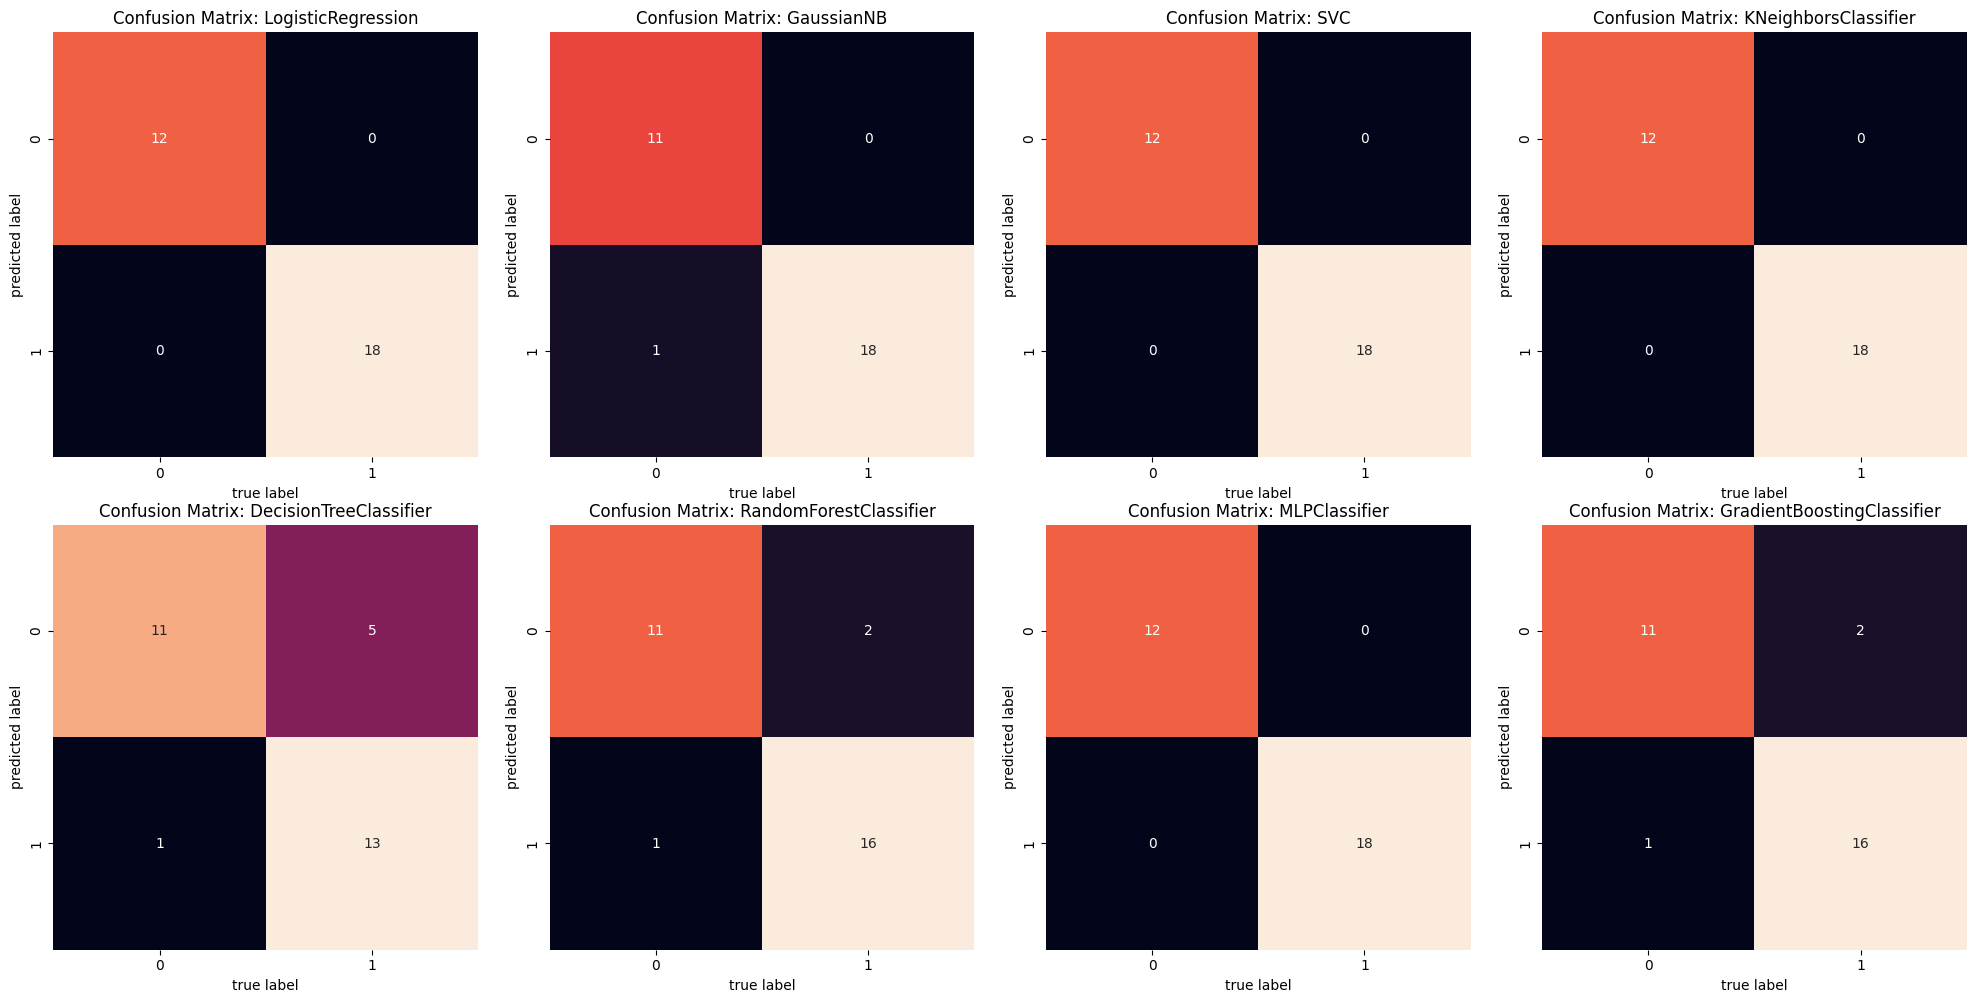

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression 0           0.000000  1.000000   1.000000   
                    1           0.000000  1.000000   1.000000   
Naive_Bayes         0           0.033333  0.958333   1.000000   
                    1           0.033333  0.958333   0.947368   
SVC                 0           0.000000  1.000000   1.000000   
                    1           0.000000  1.000000   1.000000   
KN_Neighbors        0           0.000000  1.000000   1.000000   
                    1           0.000000  1.000000   1.000000   
Decision_Tree       0           0.200000  0.819444   0.687500   
                    1           0.200000  0.819444   0.928571   
Random_Forest       0           0.100000  0.902778   0.846154   
                    1           0.100000  0.902778   0.941176   
Neural_Network      0           0.000000  1.000000   1.000000   
                    1           0.000000  1.000000   1.000000   
Gradient_Boosting   0           0.100000  0.902778   0.846154   
                    1           0.100000  0.902778   0.941176   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression 0                  1.000000  1.000000  
                    1                  1.000000  1.000000  
Naive_Bayes         0                  0.950000  0.916667  
                    1                  0.947368  1.000000  
SVC                 0                  1.000000  1.000000  
                    1                  1.000000  1.000000  
KN_Neighbors        0                  1.000000  1.000000  
                    1                  1.000000  1.000000  
Decision_Tree       0                  0.663542  0.916667  
                    1                  0.837302  0.722222  
Random_Forest       0                  0.808974  0.916667  
                    1                  0.903268  0.888889  
Neural_Network      0                  1.000000  1.000000  
                    1                  1.000000  1.000000  
Gradient_Boosting   0                  0.808974  0.916667  
                    1                  0.903268  0.888889

In [60]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100, n_features=5, n_informative=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the first articifical dataset, Logistic Regression, SVC, and Neural_Network perform equally the best, as shown by "zeros" in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

2. Second artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


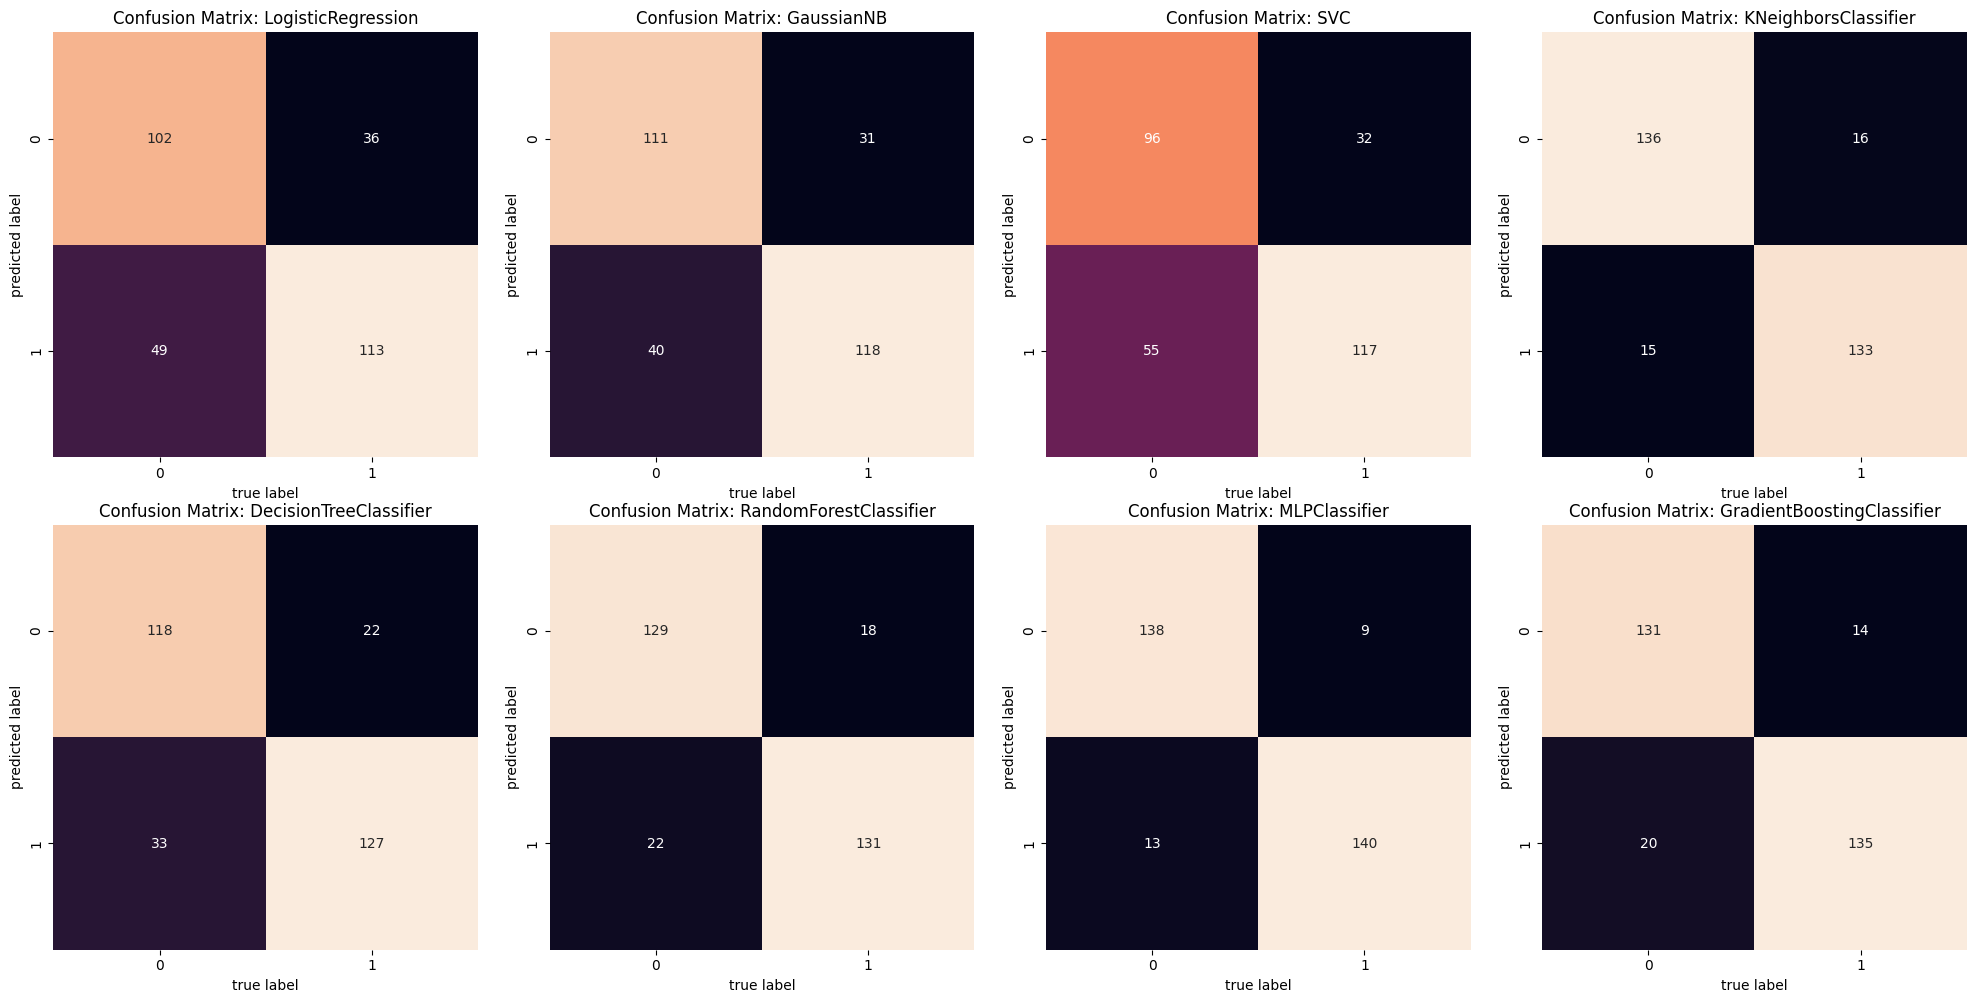

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression 0           0.283333  0.716943   0.739130   
                    1           0.283333  0.716943   0.697531   
Naive_Bayes         0           0.236667  0.763523   0.781690   
                    1           0.236667  0.763523   0.746835   
SVC                 0           0.290000  0.710498   0.750000   
                    1           0.290000  0.710498   0.680233   
KN_Neighbors        0           0.103333  0.896640   0.894737   
                    1           0.103333  0.896640   0.898649   
Decision_Tree       0           0.183333  0.816903   0.842857   
                    1           0.183333  0.816903   0.793750   
Random_Forest       0           0.133333  0.866750   0.877551   
                    1           0.133333  0.866750   0.856209   
Neural_Network      0           0.073333  0.926752   0.938776   
                    1           0.073333  0.926752   0.915033   
Gradient_Boosting   0           0.113333  0.886795   0.903448   
                    1           0.113333  0.886795   0.870968   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression 0                  0.662613  0.675497  
                    1                  0.649000  0.758389  
Naive_Bayes         0                  0.707953  0.735099  
                    1                  0.694787  0.791946  
SVC                 0                  0.660155  0.635762  
                    1                  0.640809  0.785235  
KN_Neighbors        0                  0.855856  0.900662  
                    1                  0.855483  0.892617  
Decision_Tree       0                  0.768657  0.781457  
                    1                  0.749885  0.852349  
Random_Forest       0                  0.823029  0.854305  
                    1                  0.812774  0.879195  
Neural_Network      0                  0.901287  0.913907  
                    1                  0.889762  0.939597  
Gradient_Boosting   0                  0.850453  0.867550  
                    1                  0.835799  0.906040

In [61]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=10, n_informative=8, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the second articifical dataset, neural network performs the best, as shown by the minimum count in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

3. Third artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


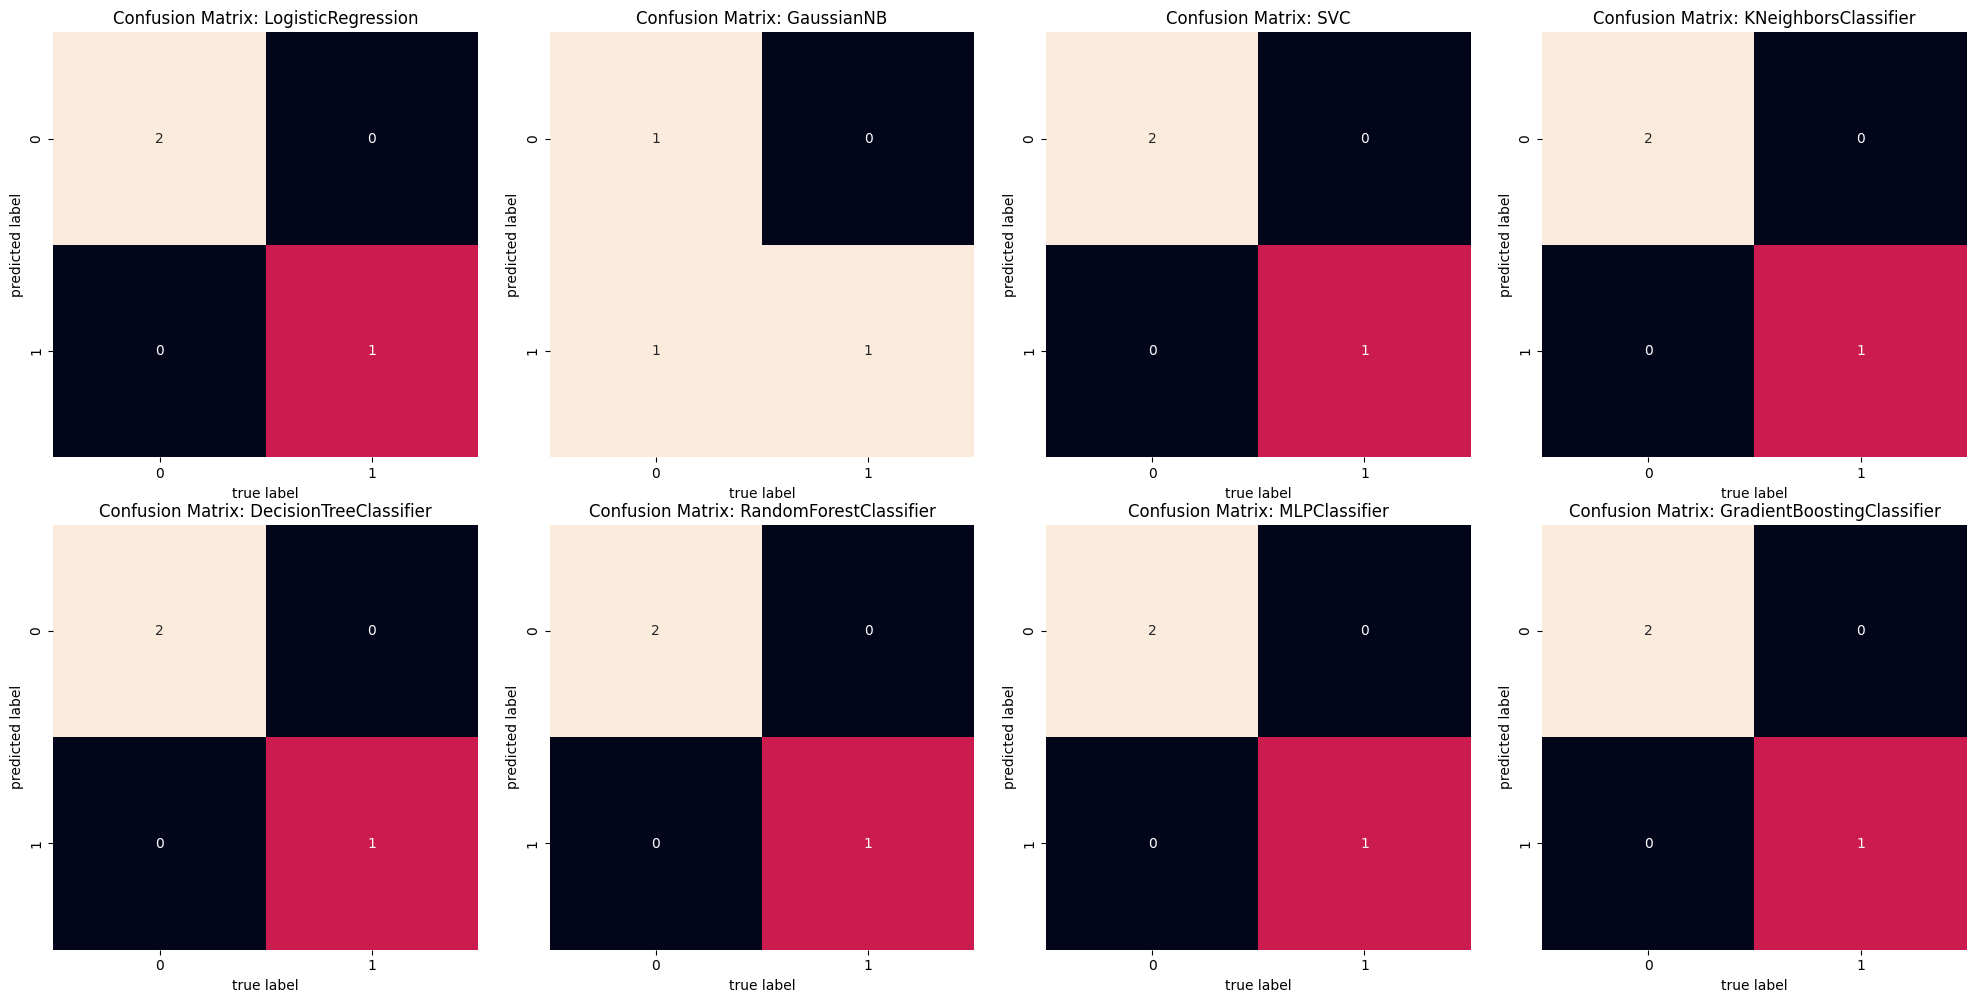

Error_Rate   AUC  Precision  Average_Precision  \
Algorithmn          Category                                                   
Logistic_Regression 0           0.000000  1.00        1.0           1.000000   
                    1           0.000000  1.00        1.0           1.000000   
Naive_Bayes         0           0.333333  0.75        1.0           0.833333   
                    1           0.333333  0.75        0.5           0.500000   
SVC                 0           0.000000  1.00        1.0           1.000000   
                    1           0.000000  1.00        1.0           1.000000   
KN_Neighbors        0           0.000000  1.00        1.0           1.000000   
                    1           0.000000  1.00        1.0           1.000000   
Decision_Tree       0           0.000000  1.00        1.0           1.000000   
                    1           0.000000  1.00        1.0           1.000000   
Random_Forest       0           0.000000  1.00        1.0           1.000000   
                    1           0.000000  1.00        1.0           1.000000   
Neural_Network      0           0.000000  1.00        1.0           1.000000   
                    1           0.000000  1.00        1.0           1.000000   
Gradient_Boosting   0           0.000000  1.00        1.0           1.000000   
                    1           0.000000  1.00        1.0           1.000000   

                              Recall  
Algorithmn          Category          
Logistic_Regression 0            1.0  
                    1            1.0  
Naive_Bayes         0            0.5  
                    1            1.0  
SVC                 0            1.0  
                    1            1.0  
KN_Neighbors        0            1.0  
                    1            1.0  
Decision_Tree       0            1.0  
                    1            1.0  
Random_Forest       0            1.0  
                    1            1.0  
Neural_Network      0            1.0  
                    1            1.0  
Gradient_Boosting   0            1.0  
                    1            1.0

In [62]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10, n_features=4, n_informative=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the third articifical dataset, every classification algorithmns except Naive Bayes perform equally the best, as shown by "zeros" in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

4. Fourth artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


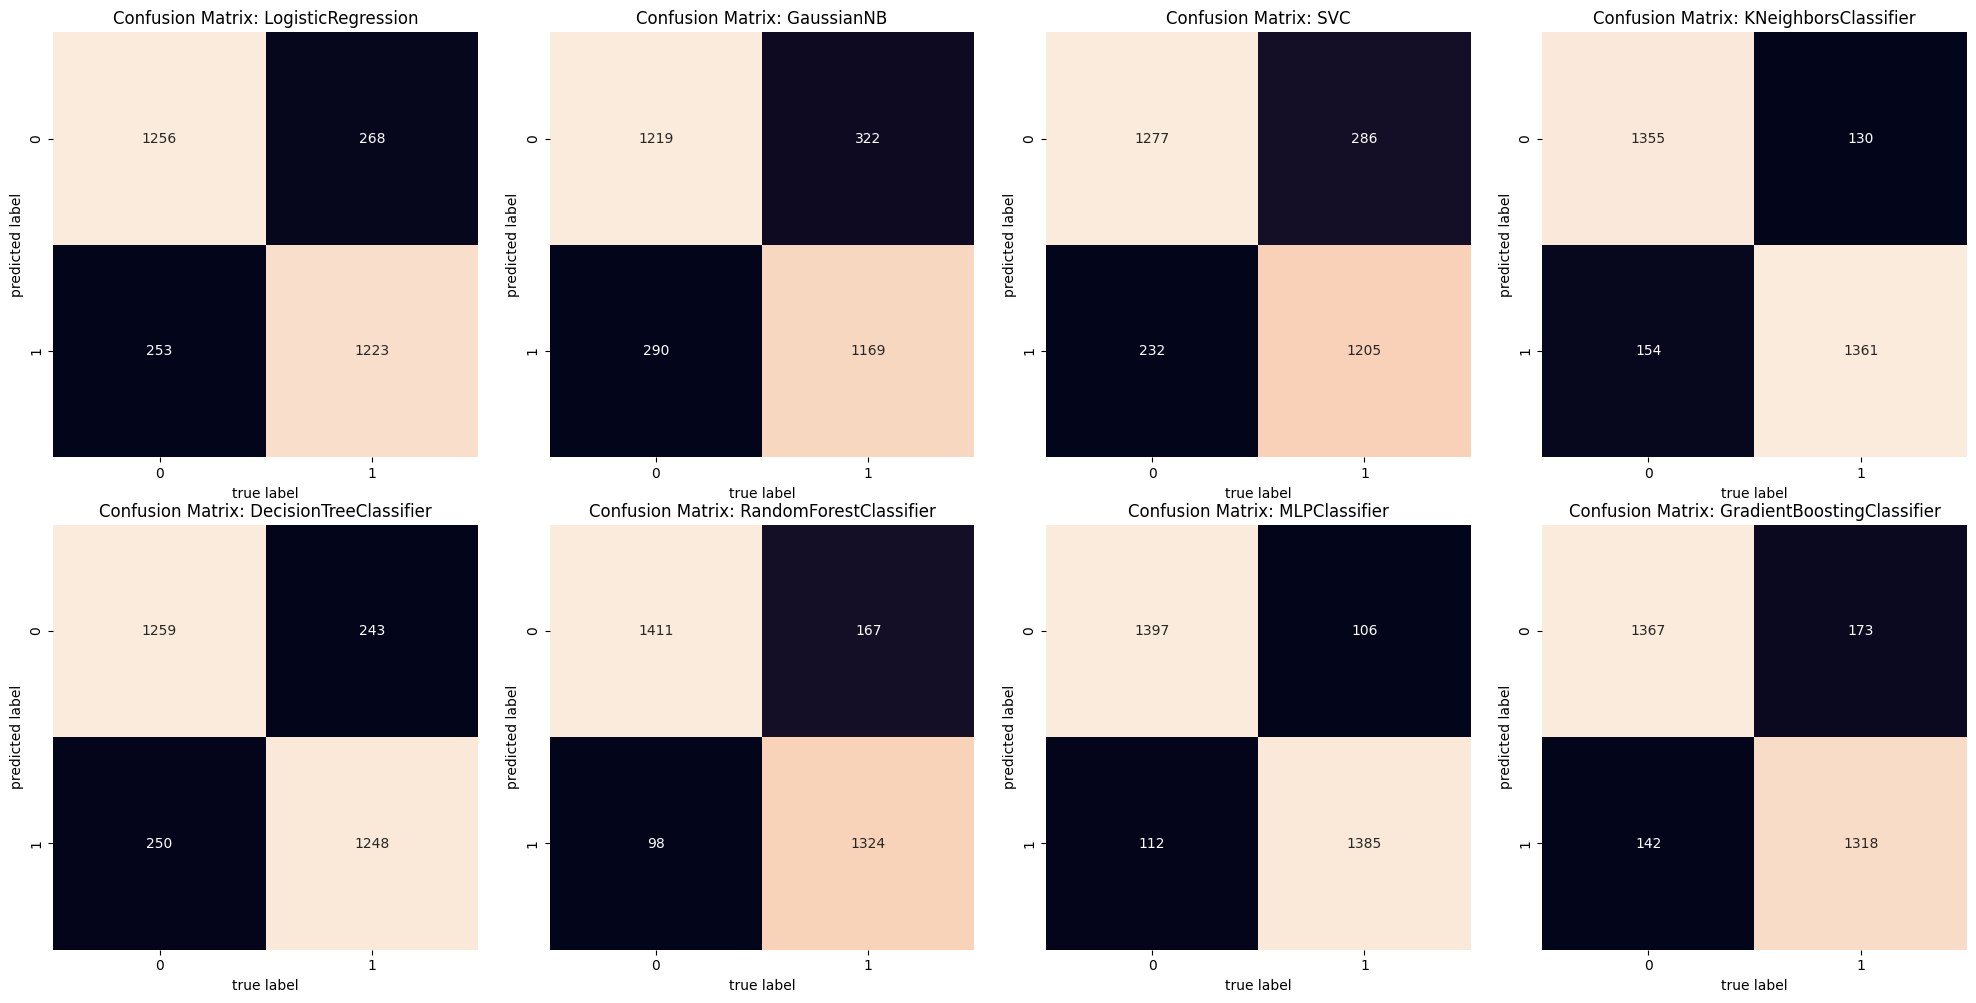

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression 0           0.173667  0.826297   0.824147   
                    1           0.173667  0.826297   0.828591   
Naive_Bayes         0           0.204000  0.795929   0.791045   
                    1           0.204000  0.795929   0.801234   
SVC                 0           0.172667  0.827219   0.817019   
                    1           0.172667  0.827219   0.838553   
KN_Neighbors        0           0.094667  0.905378   0.912458   
                    1           0.094667  0.905378   0.898350   
Decision_Tree       0           0.164333  0.835675   0.838216   
                    1           0.164333  0.835675   0.833111   
Random_Forest       0           0.088333  0.911525   0.894170   
                    1           0.088333  0.911525   0.931083   
Neural_Network      0           0.072667  0.927343   0.929474   
                    1           0.072667  0.927343   0.925184   
Gradient_Boosting   0           0.105000  0.894934   0.887662   
                    1           0.105000  0.894934   0.902740   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression 0                  0.770303  0.832339  
                    1                  0.768989  0.820255  
Naive_Bayes         0                  0.735688  0.807820  
                    1                  0.735531  0.784038  
SVC                 0                  0.768740  0.846256  
                    1                  0.773037  0.808182  
KN_Neighbors        0                  0.870671  0.897946  
                    1                  0.863356  0.912810  
Decision_Tree       0                  0.782680  0.834327  
                    1                  0.778332  0.837022  
Random_Forest       0                  0.868766  0.935056  
                    1                  0.882463  0.887995  
Neural_Network      0                  0.897821  0.925779  
                    1                  0.894743  0.928907  
Gradient_Boosting   0                  0.851465  0.905898  
                    1                  0.855662  0.883970

In [63]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, n_features=30, n_informative=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the fourth articifical dataset, neural network performs the best, as shown by the minimum count in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

5. Fifth artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


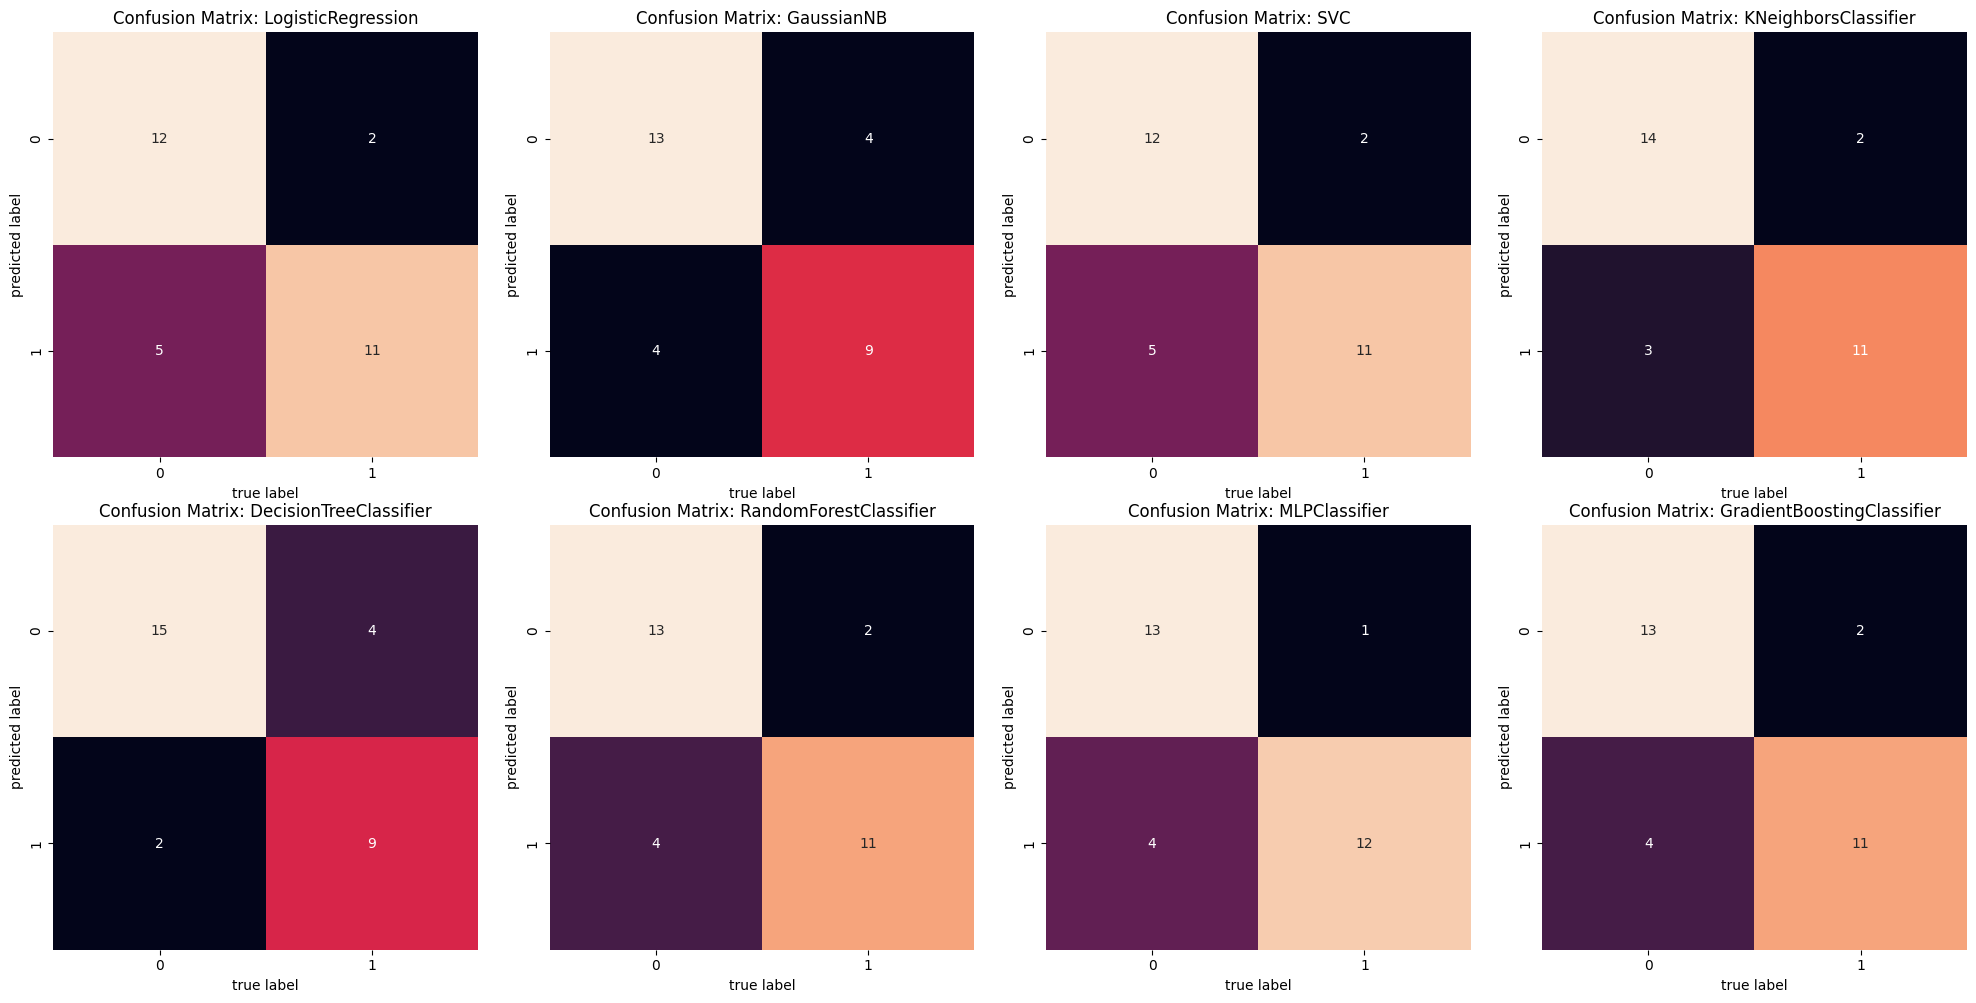

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression 0           0.233333  0.776018   0.857143   
                    1           0.233333  0.776018   0.687500   
Naive_Bayes         0           0.266667  0.728507   0.764706   
                    1           0.266667  0.728507   0.692308   
SVC                 0           0.233333  0.776018   0.857143   
                    1           0.233333  0.776018   0.687500   
KN_Neighbors        0           0.166667  0.834842   0.875000   
                    1           0.166667  0.834842   0.785714   
Decision_Tree       0           0.200000  0.787330   0.789474   
                    1           0.200000  0.787330   0.818182   
Random_Forest       0           0.200000  0.805430   0.866667   
                    1           0.200000  0.805430   0.733333   
Neural_Network      0           0.166667  0.843891   0.928571   
                    1           0.166667  0.843891   0.750000   
Gradient_Boosting   0           0.200000  0.805430   0.866667   
                    1           0.200000  0.805430   0.733333   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression 0                  0.771709  0.705882  
                    1                  0.648397  0.846154  
Naive_Bayes         0                  0.718108  0.764706  
                    1                  0.612623  0.692308  
SVC                 0                  0.771709  0.705882  
                    1                  0.648397  0.846154  
KN_Neighbors        0                  0.820588  0.823529  
                    1                  0.731502  0.846154  
Decision_Tree       0                  0.763261  0.882353  
                    1                  0.699767  0.692308  
Random_Forest       0                  0.796078  0.764706  
                    1                  0.687179  0.846154  
Neural_Network      0                  0.843417  0.764706  
                    1                  0.725641  0.923077  
Gradient_Boosting   0                  0.796078  0.764706  
                    1                  0.687179  0.846154

In [64]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100, n_features=30, n_informative=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the fifth articifical dataset, KN-neightbors, random forest, neural network, and gradient boosting performs the best, as shown by the minimum count in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

6. Sixth artifical dataset

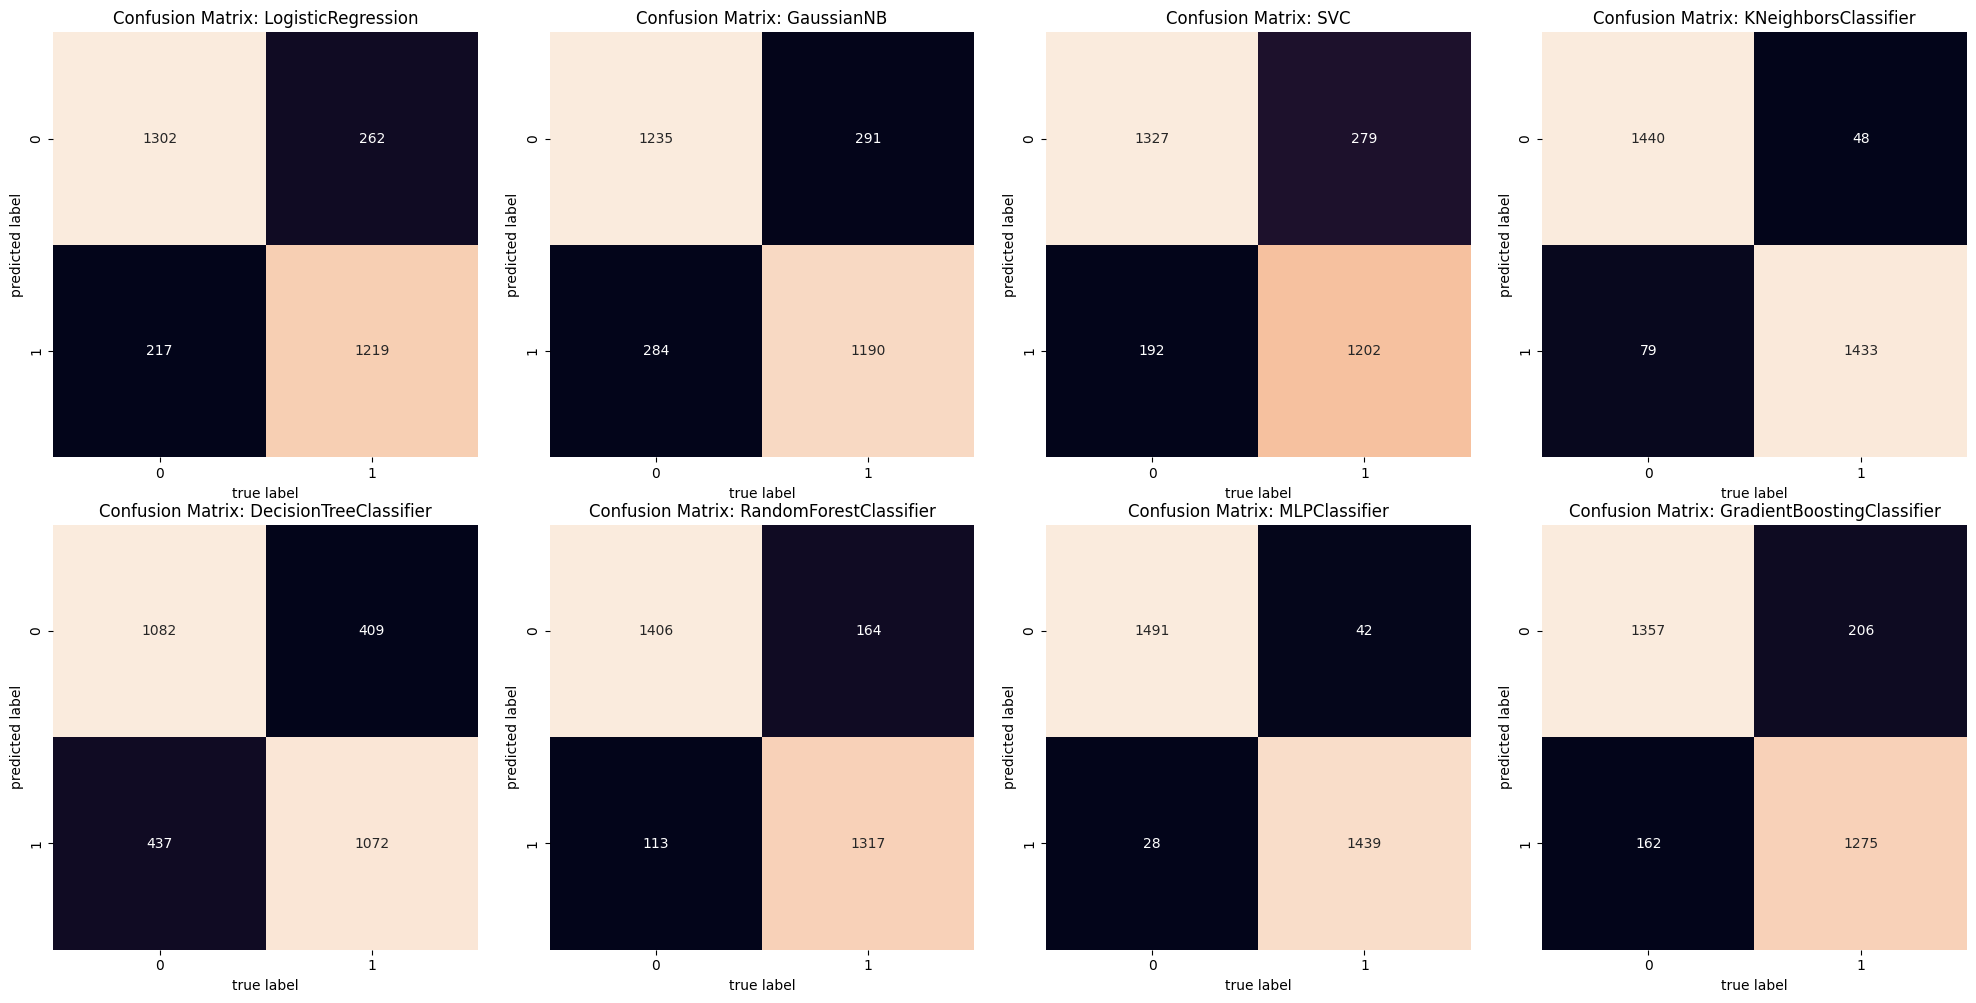

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression 0           0.159667  0.840118   0.832481   
                    1           0.159667  0.840118   0.848886   
Naive_Bayes         0           0.191667  0.808273   0.809305   
                    1           0.191667  0.808273   0.807327   
SVC                 0           0.157000  0.842607   0.826276   
                    1           0.157000  0.842607   0.862267   
KN_Neighbors        0           0.042333  0.957791   0.967742   
                    1           0.042333  0.957791   0.947751   
Decision_Tree       0           0.282000  0.718073   0.725687   
                    1           0.282000  0.718073   0.710404   
Random_Forest       0           0.092333  0.907436   0.895541   
                    1           0.092333  0.907436   0.920979   
Neural_Network      0           0.023333  0.976604   0.972603   
                    1           0.023333  0.976604   0.980913   
Gradient_Boosting   0           0.122667  0.877128   0.868202   
                    1           0.122667  0.877128   0.887265   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression 0                  0.785888  0.857143  
                    1                  0.786045  0.823093  
Naive_Bayes         0                  0.752660  0.813035  
                    1                  0.745696  0.803511  
SVC                 0                  0.785836  0.873601  
                    1                  0.792828  0.811614  
KN_Neighbors        0                  0.943745  0.947992  
                    1                  0.933034  0.967589  
Decision_Tree       0                  0.662582  0.712311  
                    1                  0.650549  0.723835  
Random_Forest       0                  0.866588  0.925609  
                    1                  0.873660  0.889264  
Neural_Network      0                  0.964008  0.981567  
                    1                  0.967095  0.971641  
Gradient_Boosting   0                  0.829609  0.893351  
                    1                  0.832517  0.860905

In [65]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=10000, n_features=80, n_informative=60, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the sixth articifical dataset, neural network performs the best, as shown by the minimum count in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

7. Seventh artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


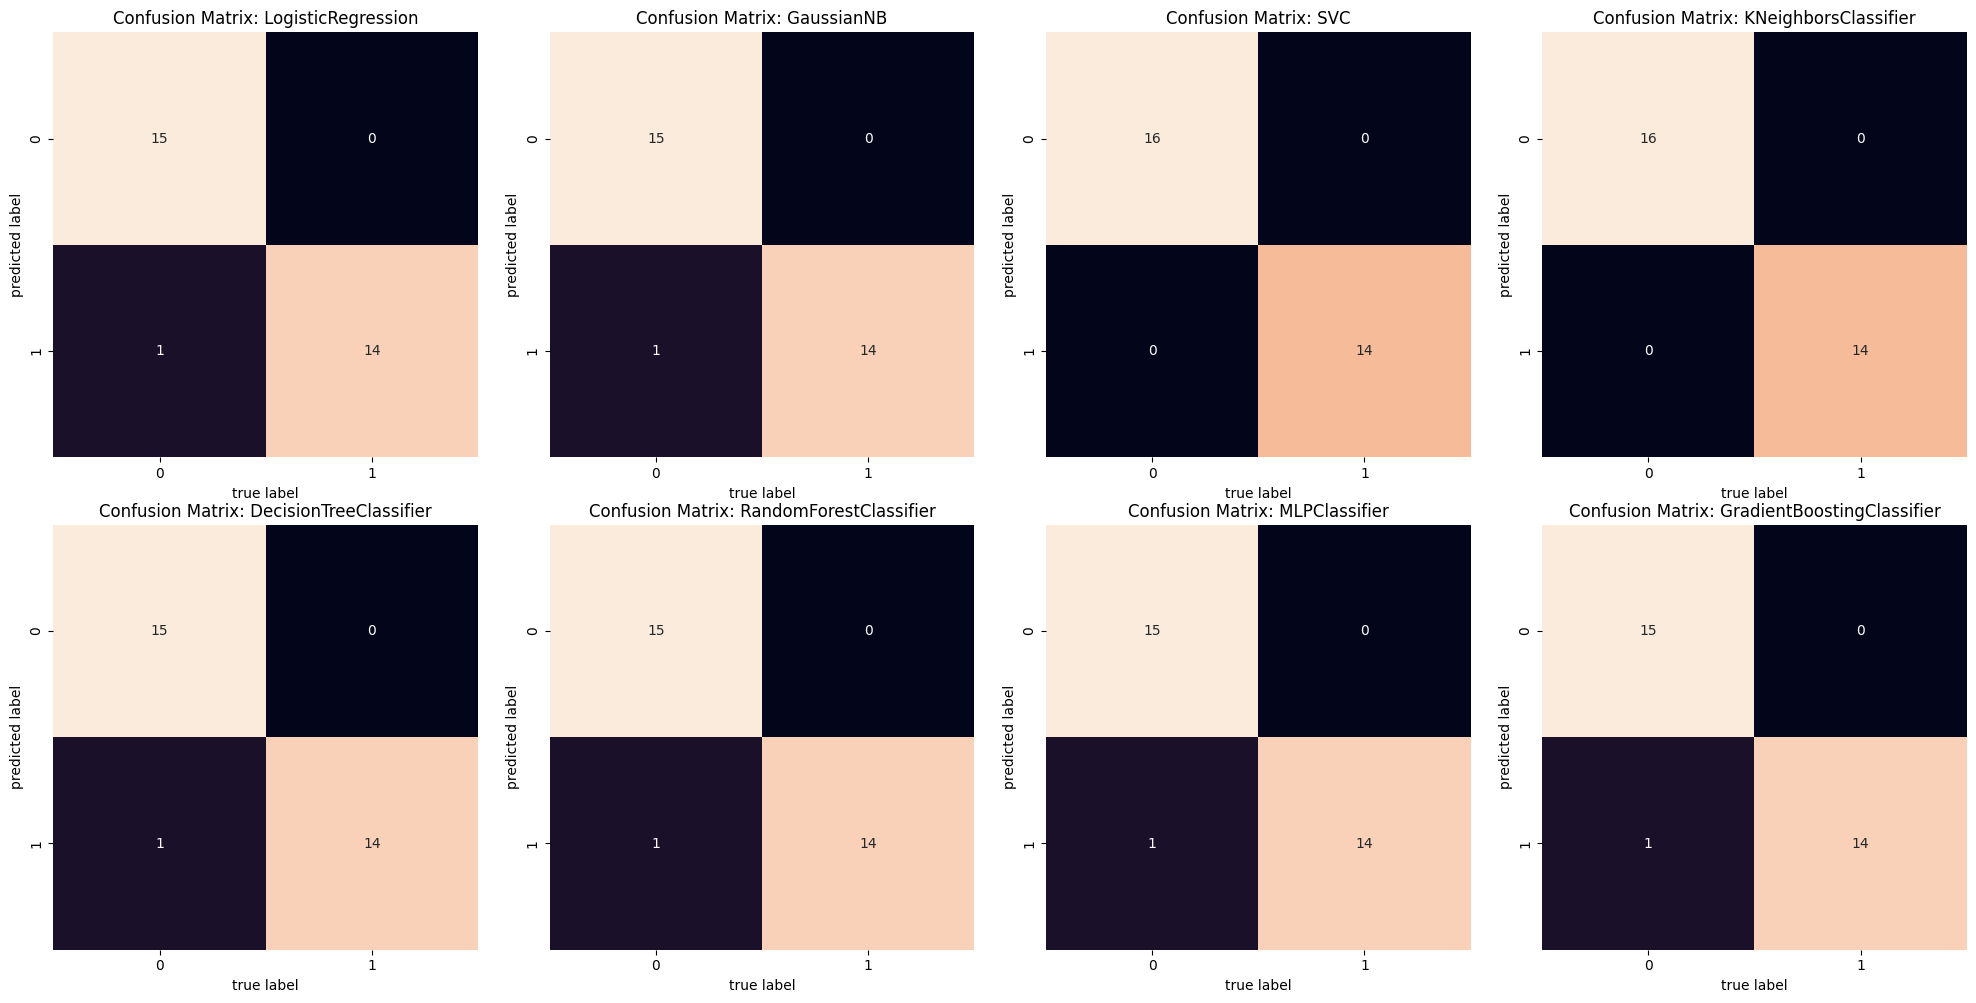

Error_Rate      AUC  Precision  \
Algorithmn          Category                                   
Logistic_Regression 0           0.033333  0.96875   1.000000   
                    1           0.033333  0.96875   0.933333   
Naive_Bayes         0           0.033333  0.96875   1.000000   
                    1           0.033333  0.96875   0.933333   
SVC                 0           0.000000  1.00000   1.000000   
                    1           0.000000  1.00000   1.000000   
KN_Neighbors        0           0.000000  1.00000   1.000000   
                    1           0.000000  1.00000   1.000000   
Decision_Tree       0           0.033333  0.96875   1.000000   
                    1           0.033333  0.96875   0.933333   
Random_Forest       0           0.033333  0.96875   1.000000   
                    1           0.033333  0.96875   0.933333   
Neural_Network      0           0.033333  0.96875   1.000000   
                    1           0.033333  0.96875   0.933333   
Gradient_Boosting   0           0.033333  0.96875   1.000000   
                    1           0.033333  0.96875   0.933333   

                              Average_Precision  Recall  
Algorithmn          Category                             
Logistic_Regression 0                  0.970833  0.9375  
                    1                  0.933333  1.0000  
Naive_Bayes         0                  0.970833  0.9375  
                    1                  0.933333  1.0000  
SVC                 0                  1.000000  1.0000  
                    1                  1.000000  1.0000  
KN_Neighbors        0                  1.000000  1.0000  
                    1                  1.000000  1.0000  
Decision_Tree       0                  0.970833  0.9375  
                    1                  0.933333  1.0000  
Random_Forest       0                  0.970833  0.9375  
                    1                  0.933333  1.0000  
Neural_Network      0                  0.970833  0.9375  
                    1                  0.933333  1.0000  
Gradient_Boosting   0                  0.970833  0.9375  
                    1                  0.933333  1.0000

In [66]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=100, n_features=2, n_redundant = 0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the seventh articifical dataset, SVC, KN-Neighbors, and Neural_Network perform equally the best, as shown by the minimum counts in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

8. Eighth artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


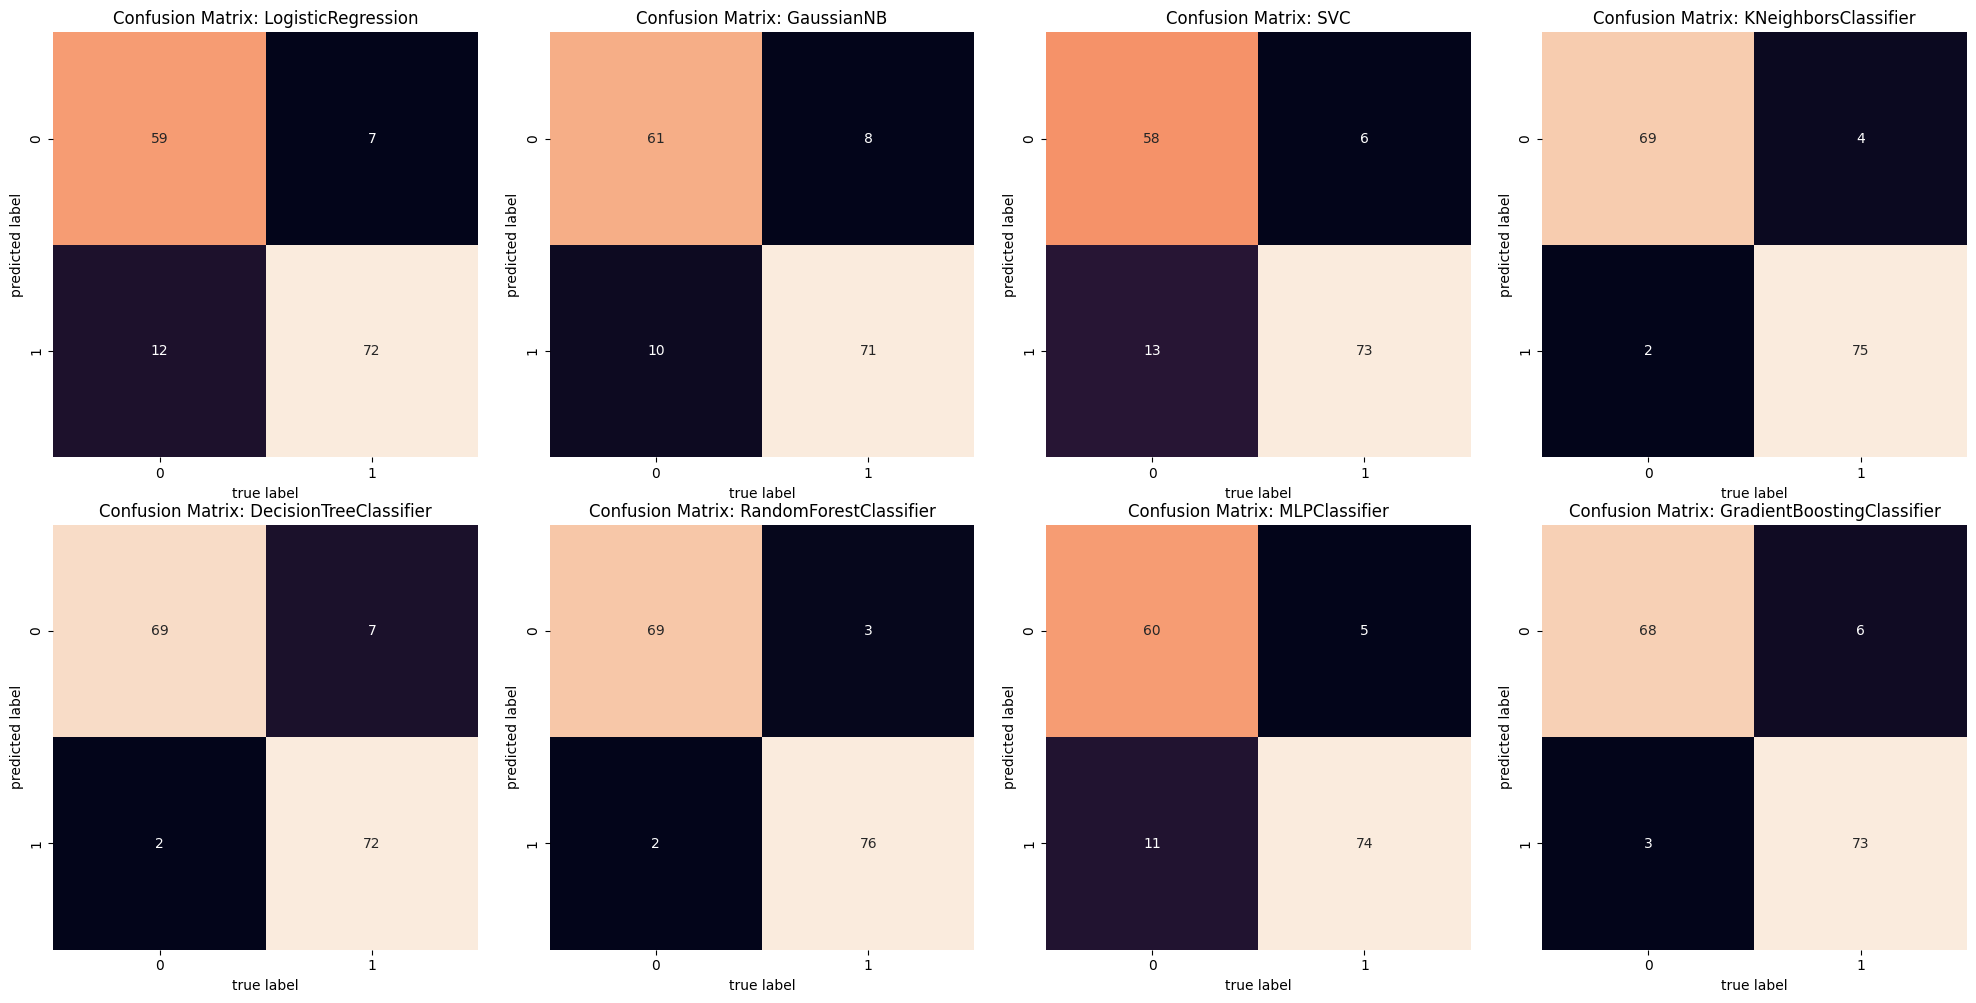

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression 0           0.126667  0.871189   0.893939   
                    1           0.126667  0.871189   0.857143   
Naive_Bayes         0           0.120000  0.878945   0.884058   
                    1           0.120000  0.878945   0.876543   
SVC                 0           0.126667  0.870476   0.906250   
                    1           0.126667  0.870476   0.848837   
KN_Neighbors        0           0.040000  0.960599   0.945205   
                    1           0.040000  0.960599   0.974026   
Decision_Tree       0           0.060000  0.941612   0.907895   
                    1           0.060000  0.941612   0.972973   
Random_Forest       0           0.033333  0.966928   0.958333   
                    1           0.033333  0.966928   0.974359   
Neural_Network      0           0.106667  0.890890   0.923077   
                    1           0.106667  0.890890   0.870588   
Gradient_Boosting   0           0.060000  0.940899   0.918919   
                    1           0.060000  0.940899   0.960526   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression 0                  0.822851  0.830986  
                    1                  0.827860  0.911392  
Naive_Bayes         0                  0.826209  0.859155  
                    1                  0.841113  0.898734  
SVC                 0                  0.826984  0.816901  
                    1                  0.824369  0.924051  
KN_Neighbors        0                  0.931913  0.971831  
                    1                  0.951375  0.949367  
Decision_Tree       0                  0.895654  0.971831  
                    1                  0.933427  0.911392  
Random_Forest       0                  0.944671  0.971831  
                    1                  0.957358  0.962025  
Neural_Network      0                  0.853398  0.845070  
                    1                  0.848821  0.936709  
Gradient_Boosting   0                  0.900091  0.957746  
                    1                  0.927575  0.924051

In [67]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=500, n_features=4, n_informative=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the eighth articifical dataset, KN-neighbors and random forest perform equally the best, as shown by the minimum counts in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

9. Ninth artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


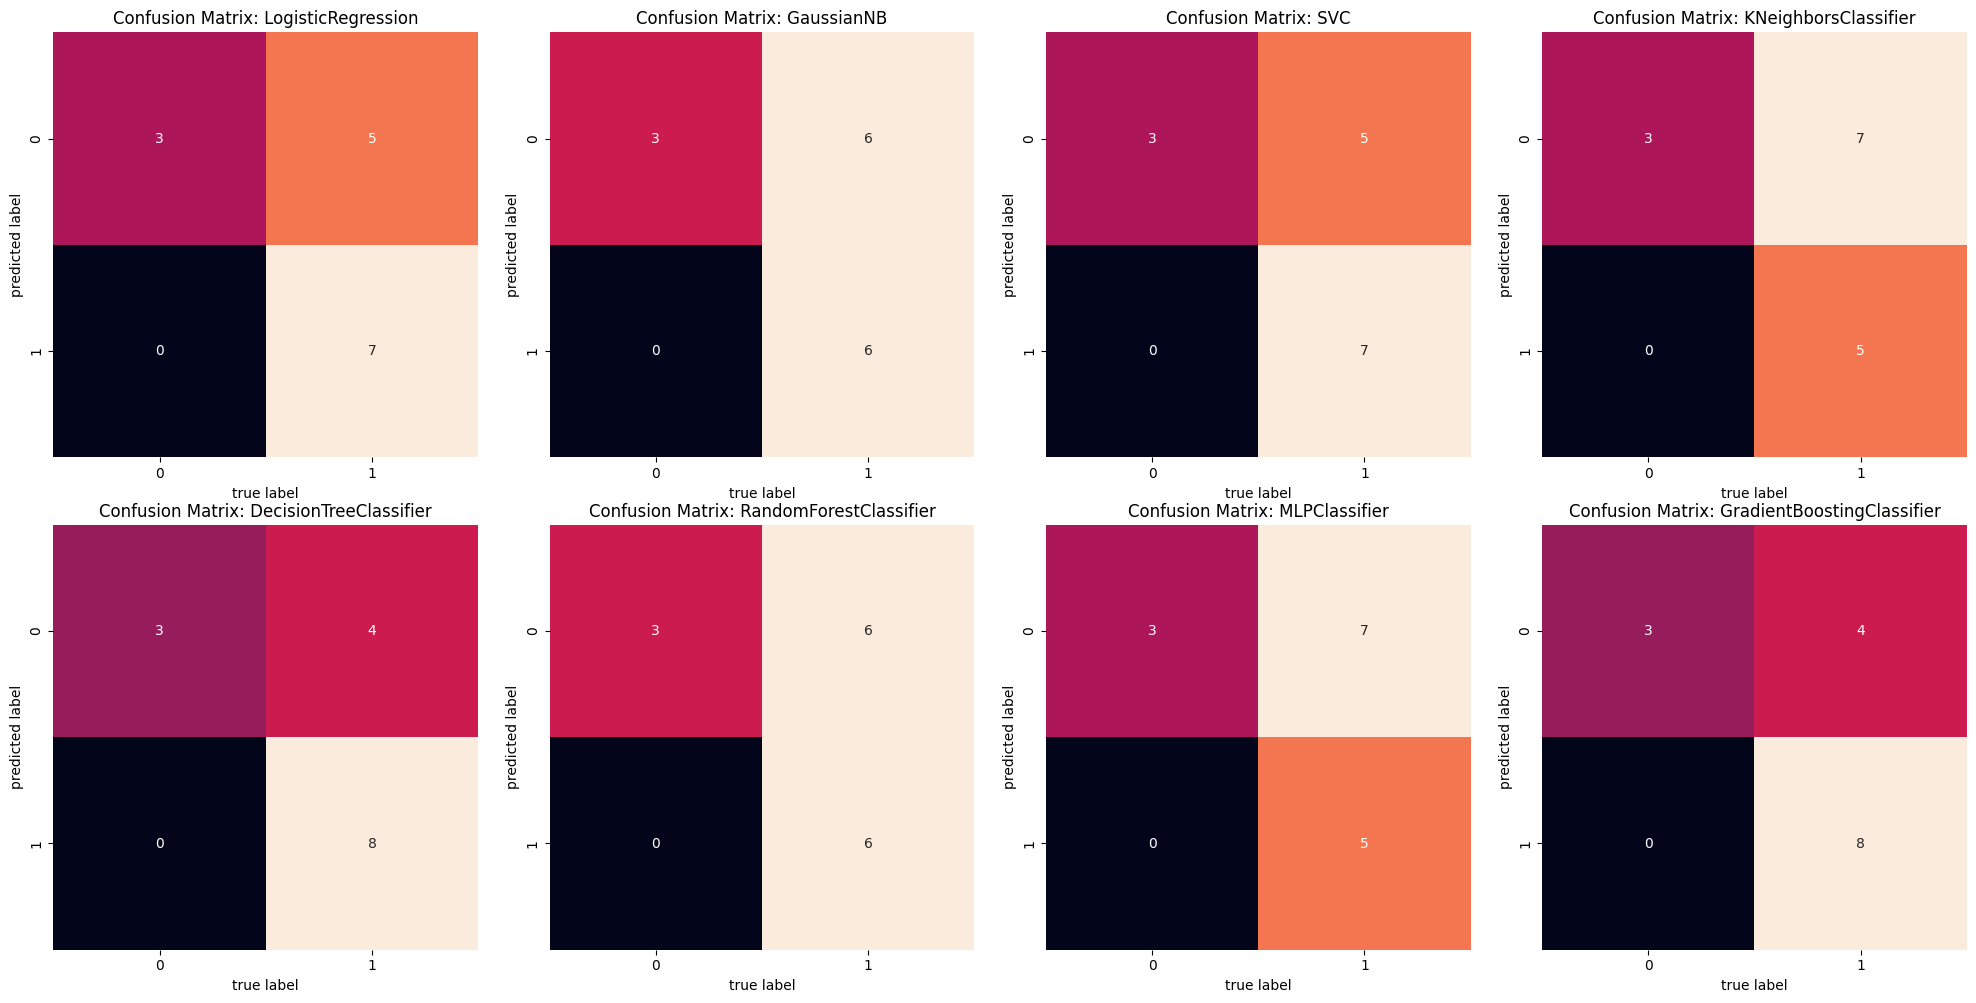

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression 0           0.333333  0.791667   0.375000   
                    1           0.333333  0.791667   1.000000   
Naive_Bayes         0           0.400000  0.750000   0.333333   
                    1           0.400000  0.750000   1.000000   
SVC                 0           0.333333  0.791667   0.375000   
                    1           0.333333  0.791667   1.000000   
KN_Neighbors        0           0.466667  0.708333   0.300000   
                    1           0.466667  0.708333   1.000000   
Decision_Tree       0           0.266667  0.833333   0.428571   
                    1           0.266667  0.833333   1.000000   
Random_Forest       0           0.400000  0.750000   0.333333   
                    1           0.400000  0.750000   1.000000   
Neural_Network      0           0.466667  0.708333   0.300000   
                    1           0.466667  0.708333   1.000000   
Gradient_Boosting   0           0.266667  0.833333   0.428571   
                    1           0.266667  0.833333   1.000000   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression 0                  0.375000  1.000000  
                    1                  0.916667  0.583333  
Naive_Bayes         0                  0.333333  1.000000  
                    1                  0.900000  0.500000  
SVC                 0                  0.375000  1.000000  
                    1                  0.916667  0.583333  
KN_Neighbors        0                  0.300000  1.000000  
                    1                  0.883333  0.416667  
Decision_Tree       0                  0.428571  1.000000  
                    1                  0.933333  0.666667  
Random_Forest       0                  0.333333  1.000000  
                    1                  0.900000  0.500000  
Neural_Network      0                  0.300000  1.000000  
                    1                  0.883333  0.416667  
Gradient_Boosting   0                  0.428571  1.000000  
                    1                  0.933333  0.666667

In [68]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=50, n_features=8, n_informative=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the ninth articifical dataset, gradient boosting performs the best, as shown by minimum counts in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

10. Tenth artifical dataset

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


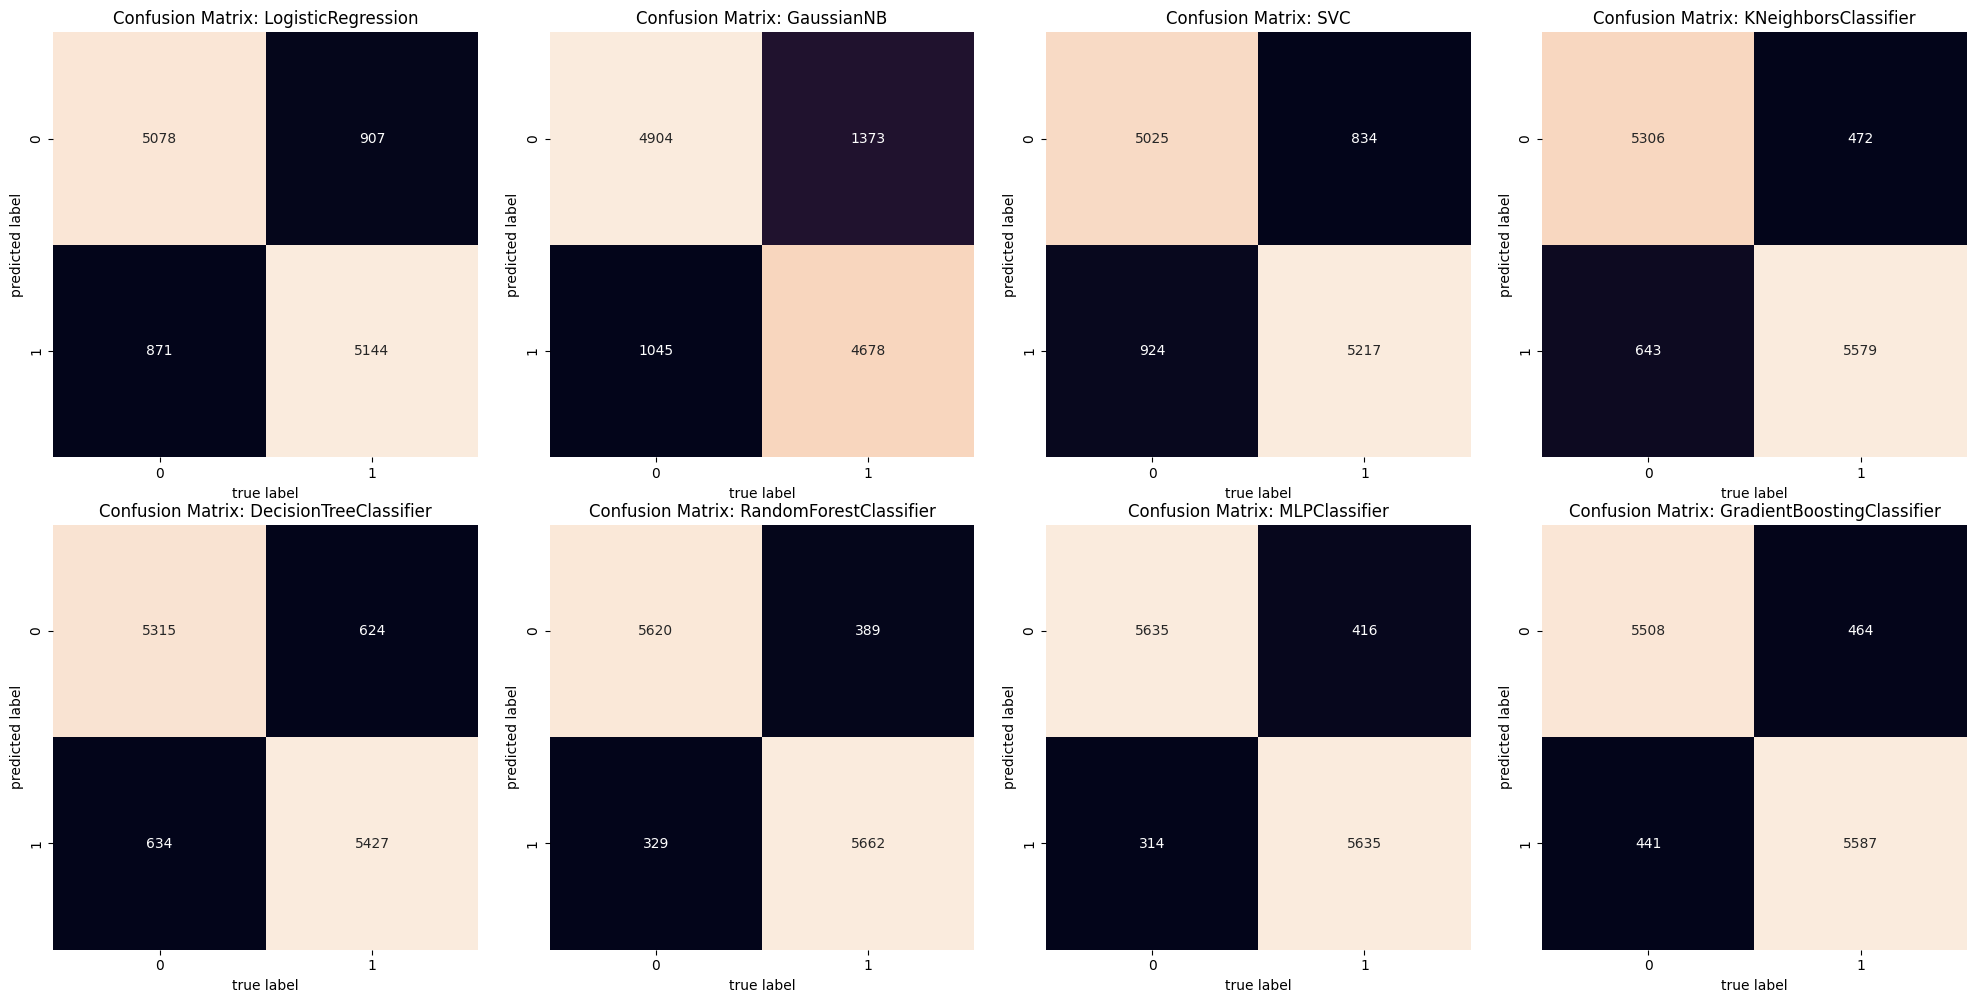

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression 0           0.148167  0.851848   0.848454   
                    1           0.148167  0.851848   0.855195   
Naive_Bayes         0           0.201500  0.798718   0.781265   
                    1           0.201500  0.798718   0.817403   
SVC                 0           0.146500  0.853426   0.857655   
                    1           0.146500  0.853426   0.849536   
KN_Neighbors        0           0.092917  0.906955   0.918311   
                    1           0.092917  0.906955   0.896657   
Decision_Tree       0           0.104833  0.895152   0.894932   
                    1           0.104833  0.895152   0.895397   
Random_Forest       0           0.059833  0.940205   0.935264   
                    1           0.059833  0.940205   0.945084   
Neural_Network      0           0.060833  0.939235   0.931251   
                    1           0.060833  0.939235   0.947218   
Gradient_Boosting   0           0.075417  0.924594   0.922304   
                    1           0.075417  0.924594   0.926841   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression 0                  0.796815  0.853589  
                    1                  0.802591  0.850107  
Naive_Bayes         0                  0.731111  0.824340  
                    1                  0.746347  0.773095  
SVC                 0                  0.801444  0.844680  
                    1                  0.801946  0.862172  
KN_Neighbors        0                  0.872638  0.891915  
                    1                  0.866048  0.921996  
Decision_Tree       0                  0.852390  0.893427  
                    1                  0.855060  0.896877  
Random_Forest       0                  0.910957  0.944697  
                    1                  0.916744  0.935713  
Neural_Network      0                  0.908264  0.947218  
                    1                  0.916764  0.931251  
Gradient_Boosting   0                  0.890684  0.925870  
                    1                  0.894436  0.923318

In [69]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=40000, n_features=20, n_informative=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

classification(X_train, X_test, y_train, y_test)

For the tenth articifical dataset, Neural Network performs the best, as shown by minimum counts in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

Using the Adaptive Boosting classifier on the tenth articifical dataset.

Adaptive Boosting intends to build a strong classifier as the combination of multiple weak classifiers by sequentially adding classifiers, each correcting its predecessor.

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0            0.13375  0.866288   0.861037           0.813818  0.870735
1            0.13375  0.866288   0.871491           0.820753  0.861841


Text(0.5, 1.0, 'Confusion Matrix')

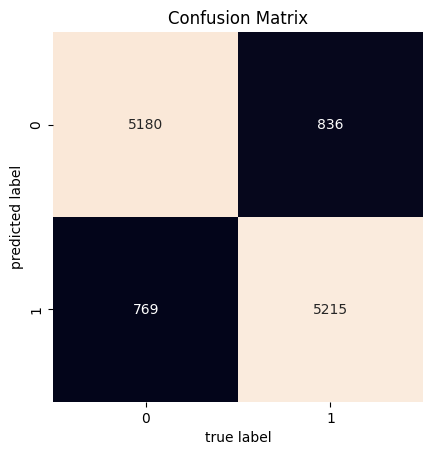

In [70]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

# Try the new classifier
base_estimator = DecisionTreeClassifier(max_depth=1)
clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
clf.fit(X_train, y_train)
print(evaluateClassifier_updated(clf, X_test, y_test))


# Plot the confusion matrix
predictions = clf.predict(X_test)
mat = sklearn.metrics.confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[str(i) for i in set(y_test)],
            yticklabels=[str(i) for i in set(y_test)])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Confusion Matrix")


Here, we can easily see that the performance is worse than the previously best classifiers (i.e., Neural Network) because it has more counts in the off-diagonals in the confusion matrices and has higher error rate and lower AUC, precision, average preceision, and recall.

### Empirical Datasets

In [71]:
# Modify the original plotConfusionMatrix function to fit my purpose
def plotConfusionMatrix_updated(clf, testDF, ax):
    import seaborn as sns
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))
    mat = sklearn.metrics.confusion_matrix(testDF['category'], predictions)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=testDF['category'].unique(), yticklabels=testDF['category'].unique(),
                ax=ax)
    ax.set_xlabel('true label')
    ax.set_ylabel('predicted label')
    ax.set_title("Confusion Matrix: " + str(clf.__class__.__name__))

# Define a function to perform all the available methods to one distinct dataset
def classification(trainDF, testDF):
    from sklearn.naive_bayes import GaussianNB

    # Define all classification algorithms used
    algorithmns = {"Logistic_Regression": sklearn.linear_model.LogisticRegression(),
                   "Naive_Bayes": GaussianNB(),
                   "SVC": sklearn.svm.SVC(kernel = 'linear', probability = True),
                   "KN_Neighbors": sklearn.neighbors.KNeighborsClassifier(5, weights='distance'),
                   "Decision_Tree": sklearn.tree.DecisionTreeClassifier(),
                   "Random_Forest": sklearn.ensemble.RandomForestClassifier(),
                   "Neural_Network": sklearn.neural_network.MLPClassifier(),
                   "Gradient_Boosting": sklearn.ensemble.GradientBoostingClassifier()}

    # Define a list to store model performance for all classification algorithms
    performance_list = []

    # Create a subplot grid of 2x4 for plotting the confusion matrix
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    # Flatten the 2D array of axes to easily iterate over it
    axes = axes.flatten()

    for idx, (i, v) in enumerate(algorithmns.items()):
        clf = v
        clf.fit(np.stack(trainDF['vect'], axis=0), trainDF["category"])
        # Evaluate the model performance
        performance = lucem_illud.evaluateClassifier(clf, testDF)
        performance_list.append(performance)

        # Plot the confusion matrix
        plotConfusionMatrix_updated(clf, testDF, axes[idx])

    # Adjust the plot layout
    plt.tight_layout()
    plt.show()

    # Return the final concatenated DataFrame (along with MultiIndex of classification algorithms)
    output = pandas.concat(performance_list, ignore_index=True)
    multiindex = pandas.MultiIndex.from_product([list(algorithmns.keys()), [str(i) for i in set(testDF["category"])]],
                                                names=['Algorithmn', 'Category'])
    output.set_index(multiindex, inplace=True)

    return output

1. NewsGroups

In [72]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


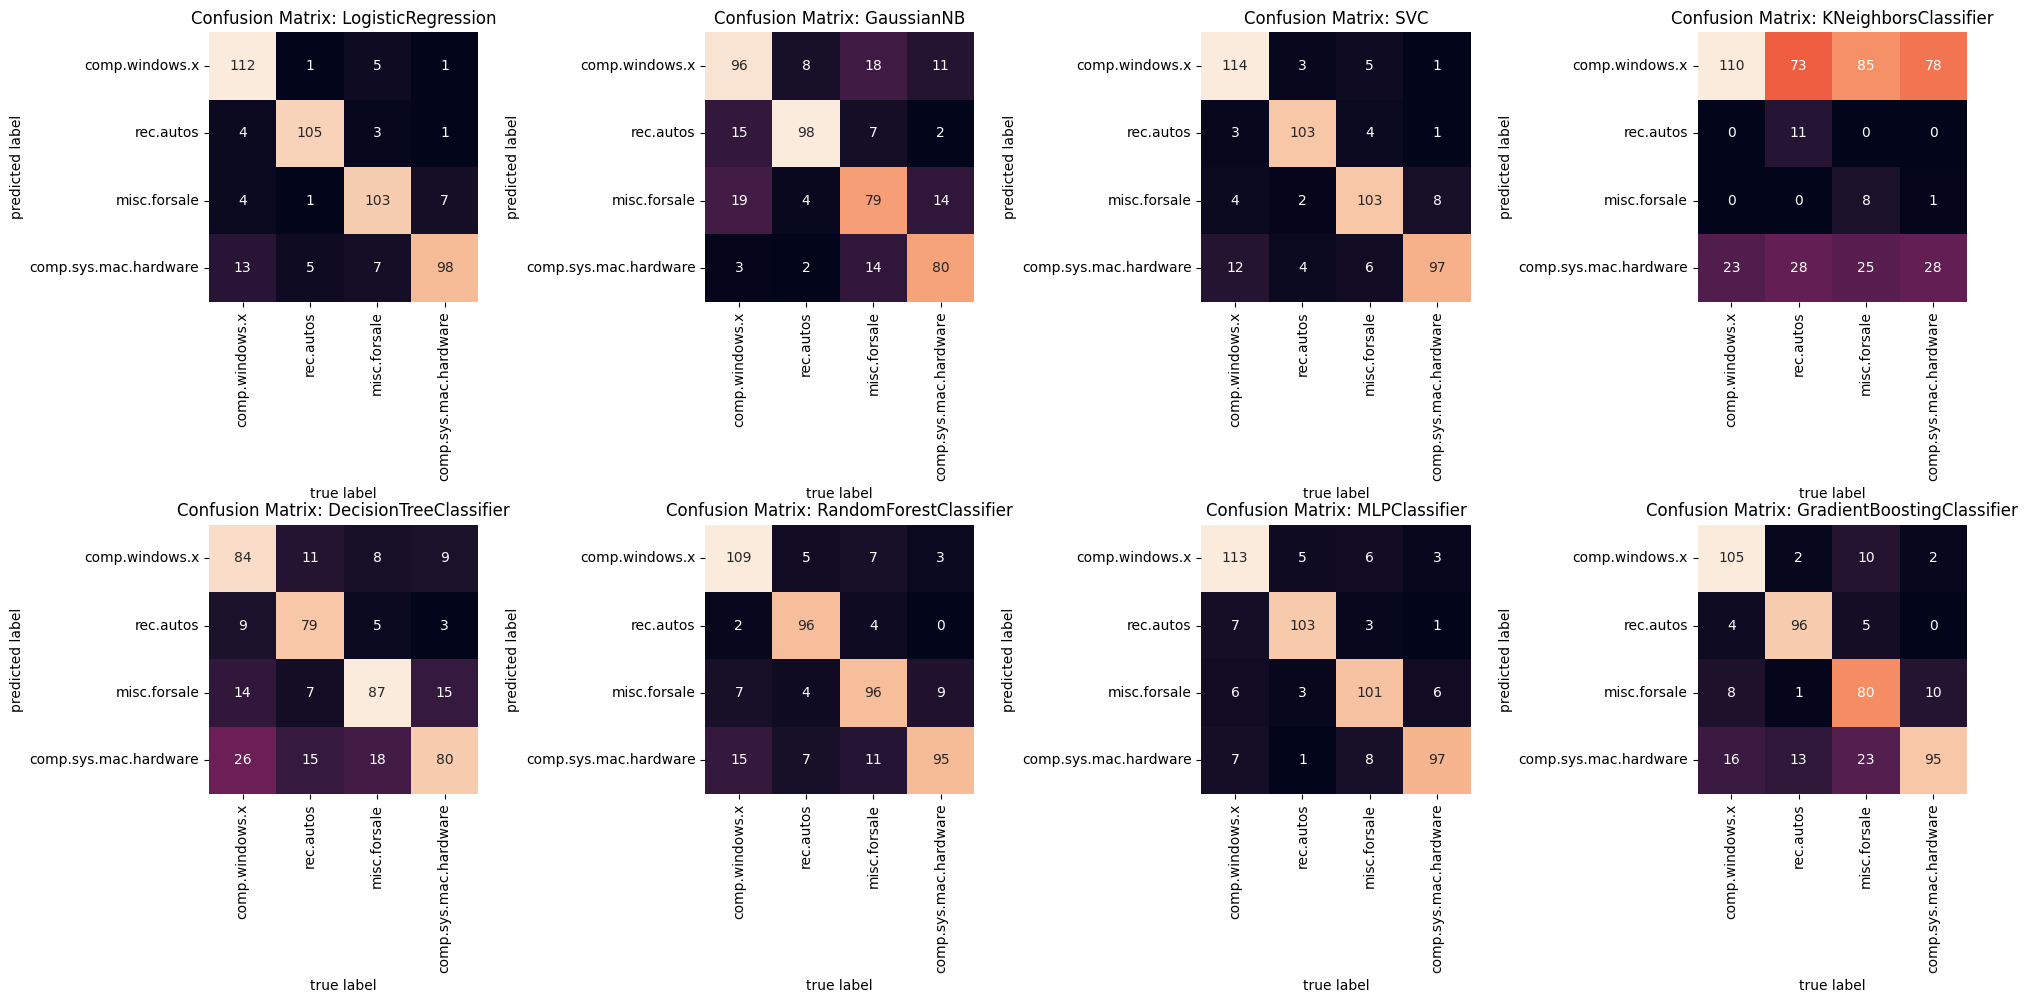

Error_Rate       AUC  Precision  \
Algorithmn          Category                                                 
Logistic_Regression comp.sys.mac.hardware    0.059574  0.910667   0.941176   
                    comp.windows.x           0.031915  0.957577   0.929204   
                    misc.forsale             0.057447  0.919395   0.895652   
                    rec.autos                0.072340  0.923509   0.796748   
Naive_Bayes         comp.sys.mac.hardware    0.157447  0.806006   0.721805   
                    comp.windows.x           0.080851  0.903980   0.803279   
                    misc.forsale             0.161702  0.782189   0.681034   
                    rec.autos                0.097872  0.847661   0.808081   
SVC                 comp.sys.mac.hardware    0.059574  0.915218   0.926829   
                    comp.windows.x           0.036170  0.948648   0.927928   
                    misc.forsale             0.061702  0.916554   0.880342   
                    rec.autos                0.068085  0.922968   0.815126   
KN_Neighbors        comp.sys.mac.hardware    0.551064  0.563385   0.317919   
                    comp.windows.x           0.214894  0.549107   1.000000   
                    misc.forsale             0.236170  0.532478   0.888889   
                    rec.autos                0.329787  0.526158   0.269231   
Decision_Tree       comp.sys.mac.hardware    0.163830  0.774246   0.750000   
                    comp.windows.x           0.106383  0.828936   0.822917   
                    misc.forsale             0.142553  0.817508   0.707317   
                    rec.autos                0.182979  0.792565   0.575540   
Random_Forest       comp.sys.mac.hardware    0.082979  0.887519   0.879032   
                    comp.windows.x           0.046809  0.920192   0.941176   
                    misc.forsale             0.089362  0.878371   0.827586   
                    rec.autos                0.095745  0.898471   0.742188   
Neural_Network      comp.sys.mac.hardware    0.072340  0.904041   0.889764   
                    comp.windows.x           0.042553  0.944458   0.903509   
                    misc.forsale             0.068085  0.906659   0.870690   
                    rec.autos                0.055319  0.931232   0.858407   
Gradient_Boosting   comp.sys.mac.hardware    0.089362  0.873965   0.882353   
                    comp.windows.x           0.053191  0.916002   0.914286   
                    misc.forsale             0.121277  0.811994   0.808081   
                    rec.autos                0.136170  0.872300   0.646259   

                                           Average_Precision    Recall  
Algorithmn          Category                                            
Logistic_Regression comp.sys.mac.hardware           0.837251  0.842105  
                    comp.windows.x                  0.886022  0.937500  
                    misc.forsale                    0.813713  0.872881  
                    rec.autos                       0.748881  0.915888  
Naive_Bayes         comp.sys.mac.hardware           0.599725  0.721805  
                    comp.windows.x                  0.732656  0.875000  
                    misc.forsale                    0.538926  0.669492  
                    rec.autos                       0.661619  0.747664  
SVC                 comp.sys.mac.hardware           0.834851  0.857143  
                    comp.windows.x                  0.872511  0.919643  
                    misc.forsale                    0.800349  0.872881  
                    rec.autos                       0.760223  0.906542  
KN_Neighbors        comp.sys.mac.hardware           0.311877  0.827068  
                    comp.windows.x                  0.313108  0.098214  
                    misc.forsale                    0.294306  0.067797  
                    rec.autos                       0.238538  0.261682  
Decision_Tree       comp.sys.mac.hardware           0.577940  0.631579  
   

In [73]:
classification(dfTrain, dfTest)

For the NewsGroups dataset, Logistic_Regression, SVC, and Neural_Network shows strong performance (particularly, Neural_Network in comp.windows.x and Logistic_Regression in comp.windows.x), as evidenced by low counts in the off-diagonals in the confusion matrices, as well as the low error rate and high AUC, precision, average preceision, and recall.

2. SenateSmall

In [74]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall('data'), test_size=.2)

Loading senate data
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


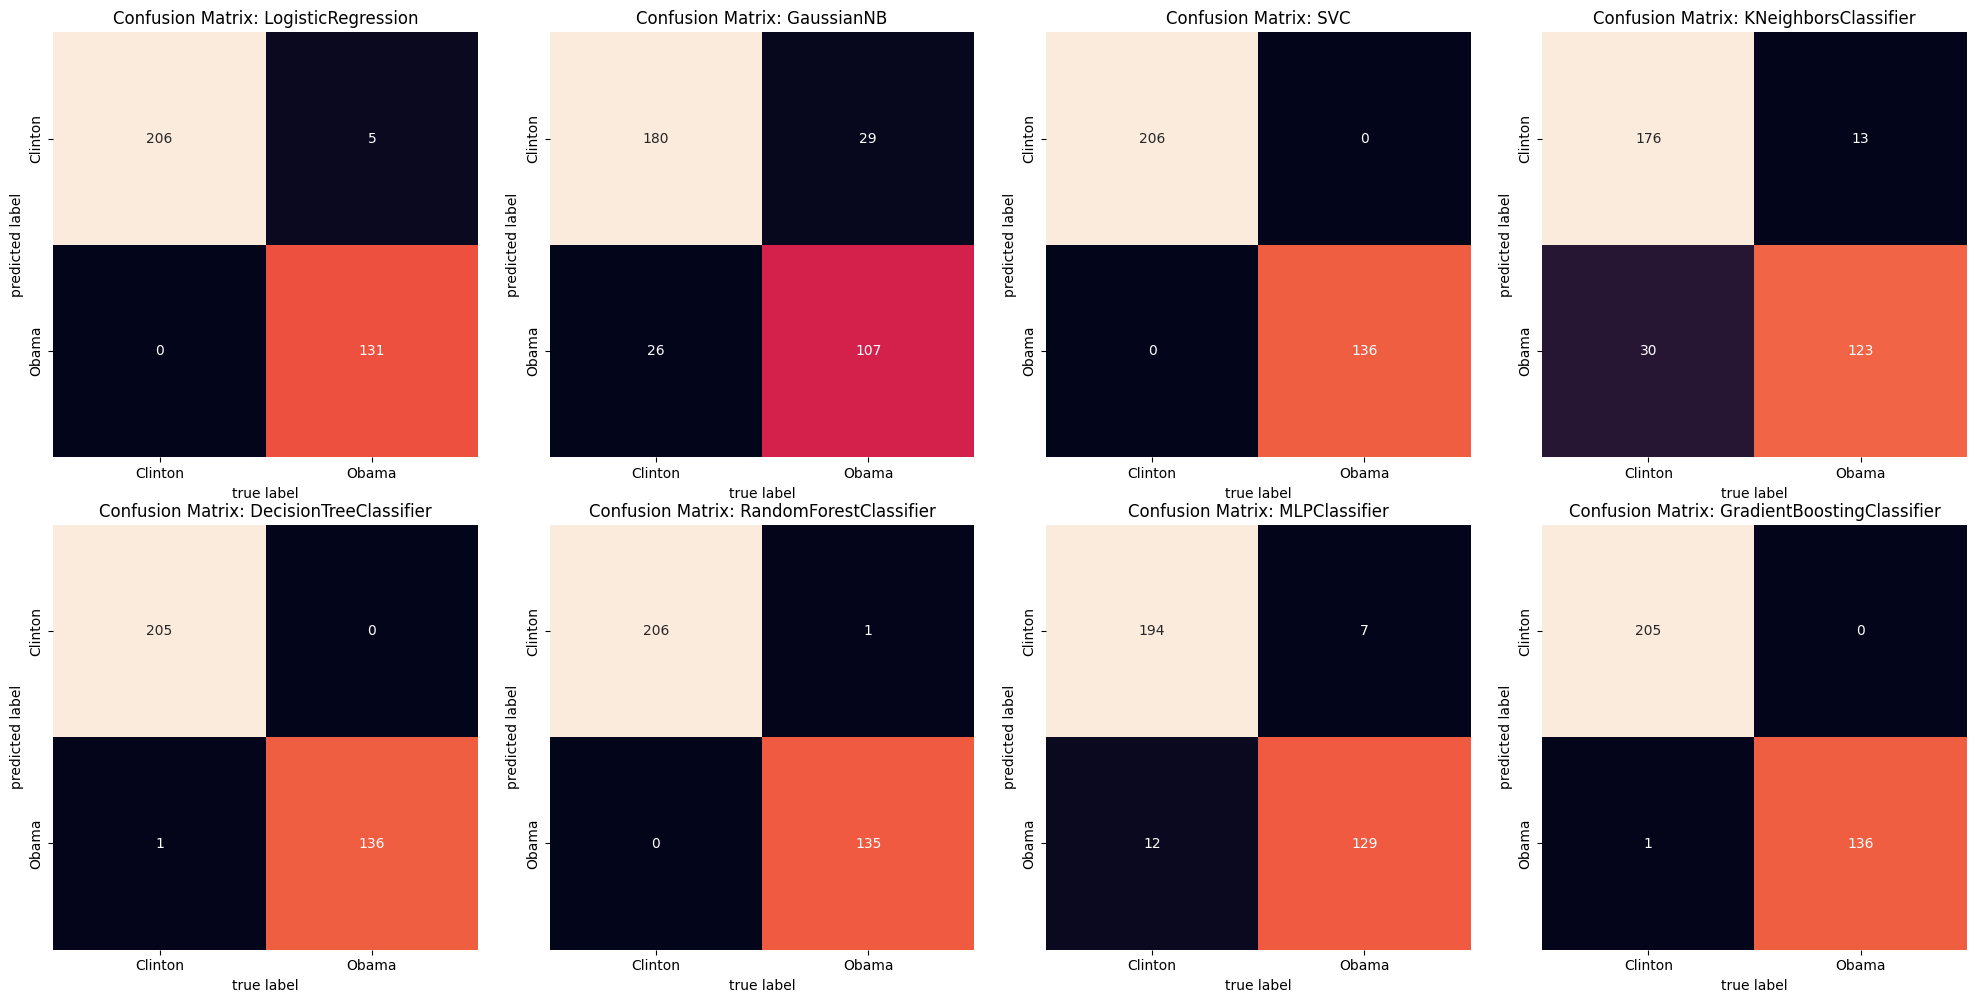

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression Clinton     0.014620  0.981618   0.976303   
                    Obama       0.014620  0.981618   1.000000   
Naive_Bayes         Clinton     0.160819  0.830276   0.861244   
                    Obama       0.160819  0.830276   0.804511   
SVC                 Clinton     0.000000  1.000000   1.000000   
                    Obama       0.000000  1.000000   1.000000   
KN_Neighbors        Clinton     0.125731  0.879390   0.931217   
                    Obama       0.125731  0.879390   0.803922   
Decision_Tree       Clinton     0.002924  0.997573   1.000000   
                    Obama       0.002924  0.997573   0.992701   
Random_Forest       Clinton     0.002924  0.996324   0.995169   
                    Obama       0.002924  0.996324   1.000000   
Neural_Network      Clinton     0.055556  0.945138   0.965174   
                    Obama       0.055556  0.945138   0.914894   
Gradient_Boosting   Clinton     0.002924  0.997573   1.000000   
                    Obama       0.002924  0.997573   0.992701   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression Clinton            0.976303  1.000000  
                    Obama              0.977855  0.963235  
Naive_Bayes         Clinton            0.828567  0.873786  
                    Obama              0.717756  0.786765  
SVC                 Clinton            1.000000  1.000000  
                    Obama              1.000000  1.000000  
KN_Neighbors        Clinton            0.883322  0.854369  
                    Obama              0.765088  0.904412  
Decision_Tree       Clinton            0.998070  0.995146  
                    Obama              0.992701  1.000000  
Random_Forest       Clinton            0.995169  1.000000  
                    Obama              0.995571  0.992647  
Neural_Network      Clinton            0.944038  0.941748  
                    Obama              0.888271  0.948529  
Gradient_Boosting   Clinton            0.998070  0.995146  
                    Obama              0.992701  1.000000

In [75]:
classification(dfTrain, dfTest)

For the SenateSmall dataset, Random_Forest performs the best, as shown by minimum counts in the off-diagonals in the confusion matrices, as well as the lowest error rate and highest AUC, precision, average preceision, and recall.

3. SenateLarge

In [76]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge('data'), test_size=.2)

Loading senator: Kennedy
Loading senator: Kohl
Loading senator: Kerry
Loading senator: Kyl
Loading senator: Klobuchar
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


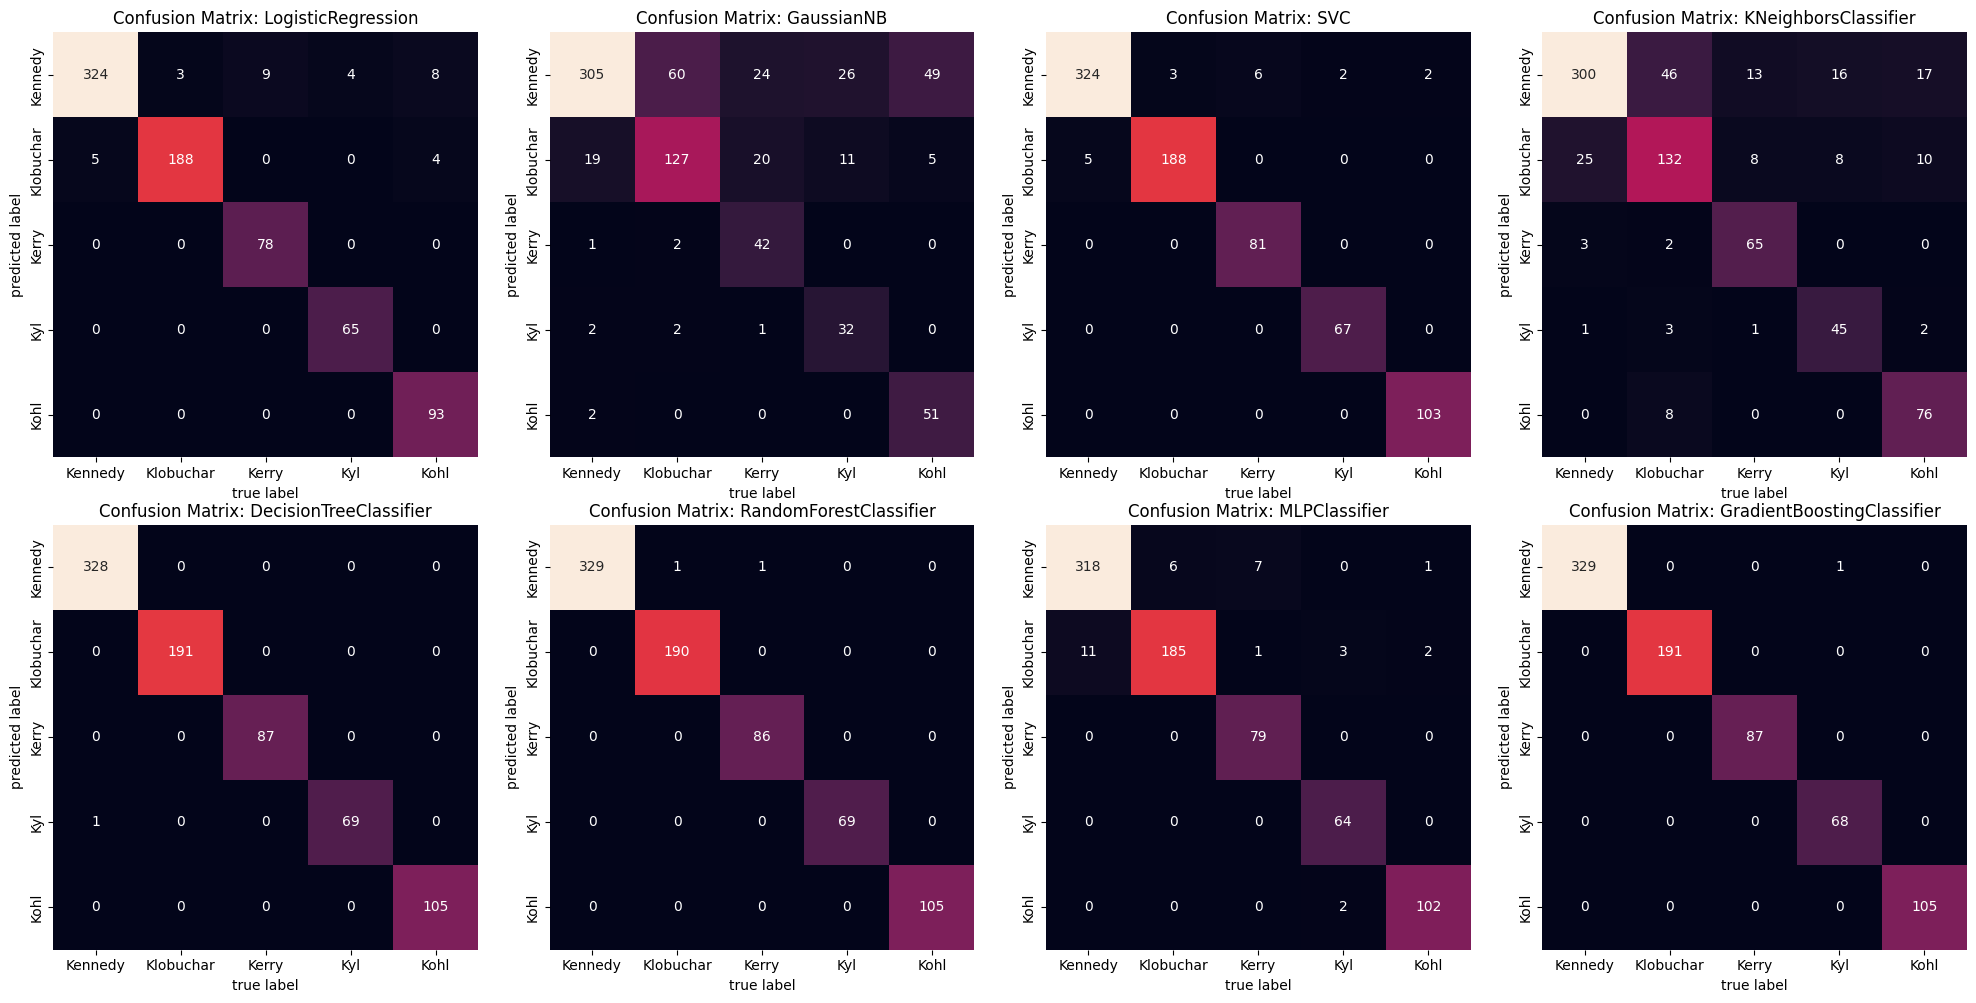

Error_Rate       AUC  Precision  \
Algorithmn          Category                                     
Logistic_Regression Kerry        0.015365  0.984519   0.954315   
                    Kennedy      0.037132  0.965853   0.931034   
                    Klobuchar    0.011524  0.948276   1.000000   
                    Kyl          0.015365  0.942857   1.000000   
                    Kohl         0.005122  0.971014   1.000000   
Naive_Bayes         Kerry        0.152369  0.785851   0.697802   
                    Kennedy      0.234315  0.787641   0.657328   
                    Klobuchar    0.061460  0.739218   0.933333   
                    Kyl          0.071703  0.741378   0.962264   
                    Kohl         0.053777  0.728373   0.864865   
SVC                 Kerry        0.010243  0.987909   0.974093   
                    Kennedy      0.023047  0.978021   0.961424   
                    Klobuchar    0.007682  0.965517   1.000000   
                    Kyl          0.002561  0.990476   1.000000   
                    Kohl         0.002561  0.985507   1.000000   
KN_Neighbors        Kerry        0.140845  0.802329   0.721311   
                    Kennedy      0.154930  0.854157   0.765306   
                    Klobuchar    0.034571  0.869961   0.928571   
                    Kyl          0.047375  0.855988   0.904762   
                    Kohl         0.039693  0.821171   0.865385   
Decision_Tree       Kerry        0.000000  1.000000   1.000000   
                    Kennedy      0.001280  0.998480   1.000000   
                    Klobuchar    0.000000  1.000000   1.000000   
                    Kyl          0.000000  1.000000   1.000000   
                    Kohl         0.001280  0.999298   0.985714   
Random_Forest       Kerry        0.001280  0.997382   1.000000   
                    Kennedy      0.002561  0.997788   0.993958   
                    Klobuchar    0.001280  0.994253   1.000000   
                    Kyl          0.000000  1.000000   1.000000   
                    Kohl         0.000000  1.000000   1.000000   
Neural_Network      Kerry        0.029449  0.969886   0.915842   
                    Kennedy      0.032010  0.967796   0.957831   
                    Klobuchar    0.010243  0.954023   1.000000   
                    Kyl          0.006402  0.984235   0.980769   
                    Kohl         0.006402  0.963768   1.000000   
Gradient_Boosting   Kerry        0.000000  1.000000   1.000000   
                    Kennedy      0.001280  0.998894   0.996970   
                    Klobuchar    0.000000  1.000000   1.000000   
                    Kyl          0.000000  1.000000   1.000000   
                    Kohl         0.001280  0.992754   1.000000   

                               Average_Precision    Recall  
Algorithmn          Category                                
Logistic_Regression Kerry               0.943167  0.984293  
                    Kennedy             0.923287  0.984802  
                    Klobuchar           0.908075  0.896552  
                    Kyl                 0.901079  0.885714  
                    Kohl                0.947151  0.942029  
Naive_Bayes         Kerry               0.545930  0.664921  
                    Kennedy             0.640106  0.927052  
                    Klobuchar           0.508193  0.482759  
                    Kyl                 0.536528  0.485714  
                    Kohl                0.448472  0.463768  
SVC                 Kerry               0.962635  0.984293  
                    Kennedy             0.953215  0.984802  
                    Klobuchar           0.938717  0.931034  
                    Kyl                 0.983513  0.980952  
                    Kohl                0.973575  0.971014  
KN_Neighbors        Kerry               0.574042  0.691099  
                    Kennedy             0.734979  0.911854  
                    Klobuchar           0.721929  0.747126  
                    Kyl               

In [77]:
classification(dfTrain, dfTest)

4. Spam

In [78]:
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(holdBackFraction = .2, dataDirectory='data'), test_size=.2)

Loading Spam
Loading Ham
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


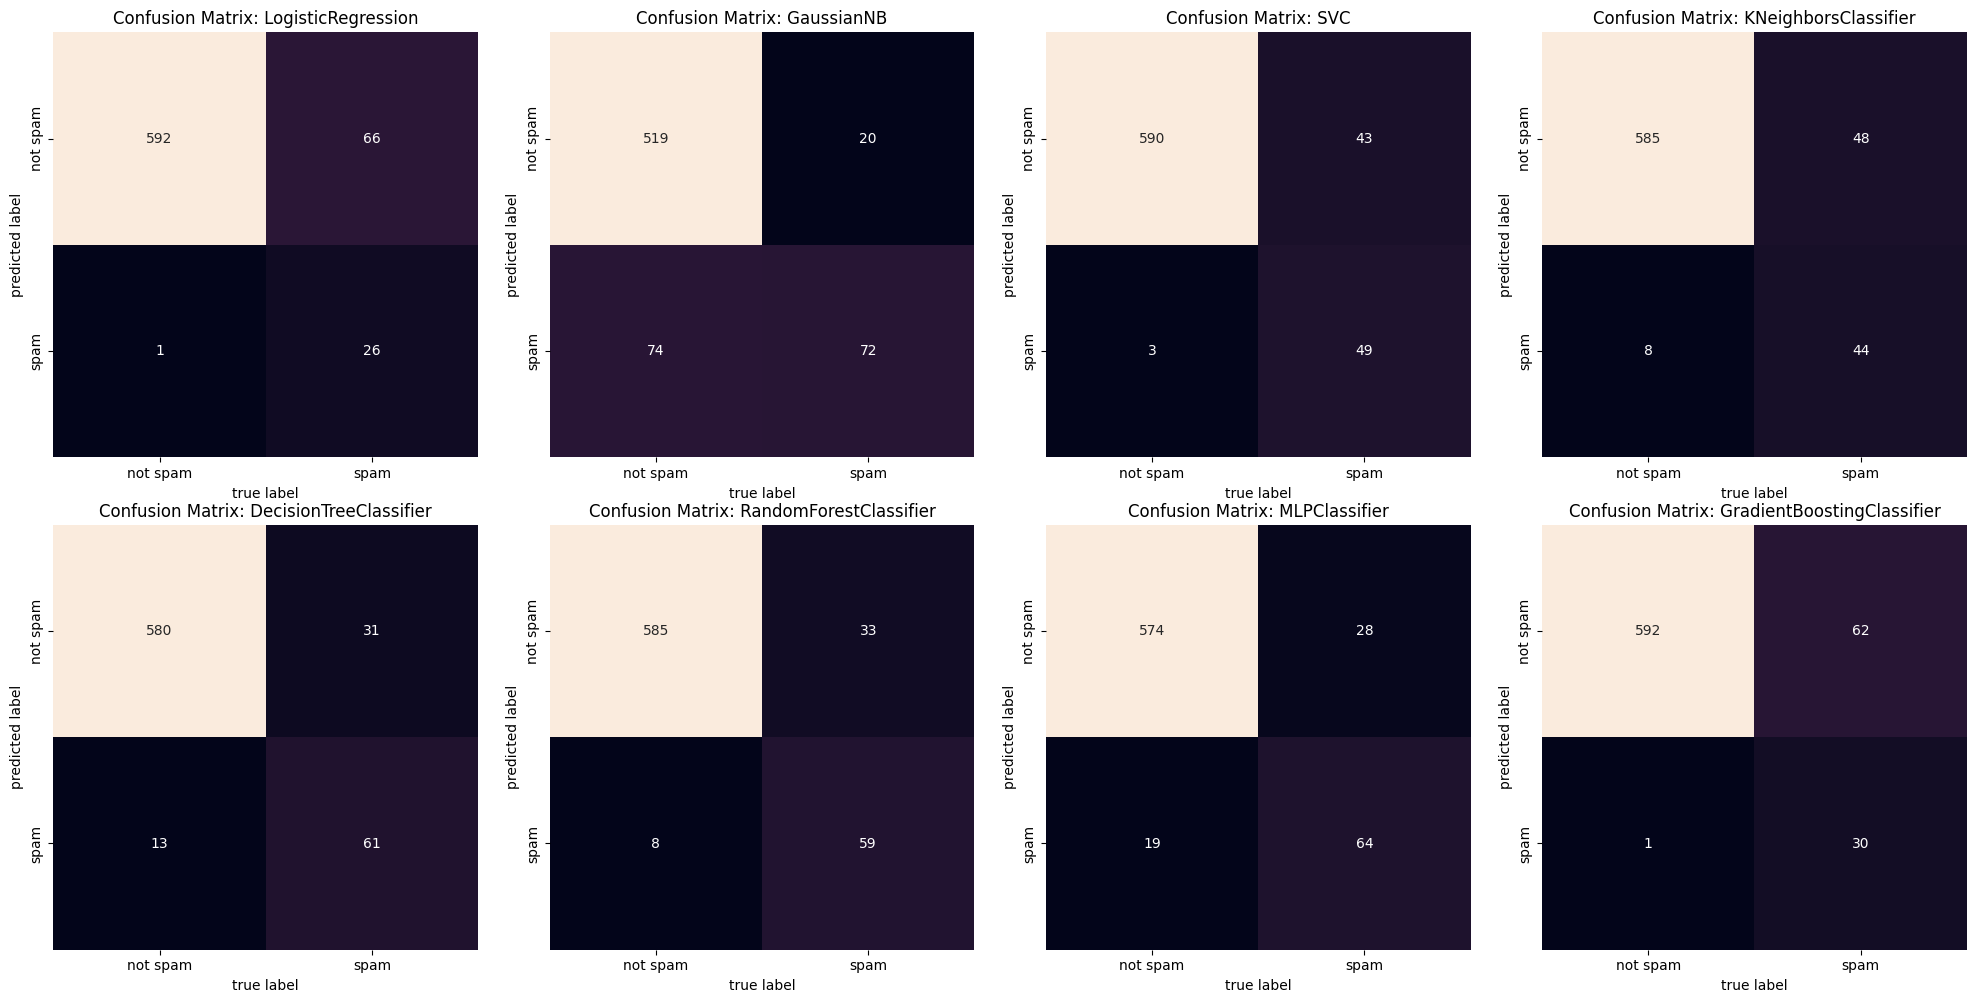

Error_Rate       AUC  Precision  \
Algorithmn          Category                                    
Logistic_Regression spam        0.097810  0.640461   0.962963   
                    not spam    0.097810  0.640461   0.899696   
Naive_Bayes         spam        0.137226  0.828910   0.493151   
                    not spam    0.137226  0.828910   0.962894   
SVC                 spam        0.067153  0.763775   0.942308   
                    not spam    0.067153  0.763775   0.932070   
KN_Neighbors        spam        0.081752  0.732385   0.846154   
                    not spam    0.081752  0.732385   0.924171   
Decision_Tree       spam        0.064234  0.820561   0.824324   
                    not spam    0.064234  0.820561   0.949264   
Random_Forest       spam        0.059854  0.813907   0.880597   
                    not spam    0.059854  0.813907   0.946602   
Neural_Network      spam        0.068613  0.831806   0.771084   
                    not spam    0.068613  0.831806   0.953488   
Gradient_Boosting   spam        0.091971  0.662200   0.967742   
                    not spam    0.091971  0.662200   0.905199   

                              Average_Precision    Recall  
Algorithmn          Category                               
Logistic_Regression spam               0.368492  0.282609  
                    not spam           0.899639  0.998314  
Naive_Bayes         spam               0.415141  0.782609  
                    not spam           0.950765  0.875211  
SVC                 spam               0.564655  0.532609  
                    not spam           0.931734  0.994941  
KN_Neighbors        spam               0.474755  0.478261  
                    not spam           0.923382  0.986509  
Decision_Tree       spam               0.591818  0.663043  
                    not spam           0.947431  0.978078  
Random_Forest       spam               0.612906  0.641304  
                    not spam           0.945510  0.986509  
Neural_Network      spam               0.577282  0.695652  
                    not spam           0.950675  0.967960  
Gradient_Boosting   spam               0.406079  0.326087  
                    not spam           0.905132  0.998314

In [79]:
classification(dfTrain, dfTest)

Using the Adaptive Boosting classifier on the Spam dataset.

Adaptive Boosting intends to build a strong classifier as the combination of multiple weak classifiers by sequentially adding classifiers, each correcting its predecessor.

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.070073  0.775863   0.866667           0.548249  0.565217
not spam    0.070073  0.775863   0.936000           0.935052  0.986509


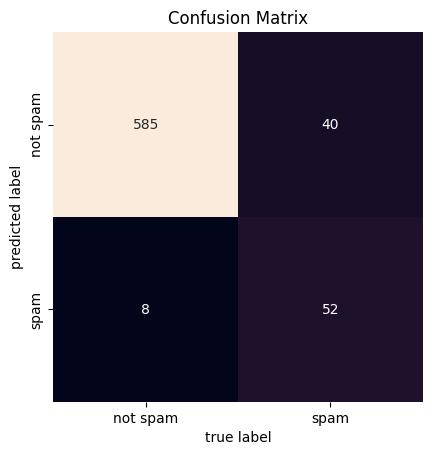

In [80]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Try the new classifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200)
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain["category"])
print(lucem_illud.evaluateClassifier(clf, dfTest))

# Plot the confusion matrix
lucem_illud.plotConfusionMatrix(clf, dfTest)

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [81]:
ObamaClintonReleases = pandas.read_csv('data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [82]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [83]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [84]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [85]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [86]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [87]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [88]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [89]:
TFVects.shape

(1367, 11531)

We can save this in the dataframe to make things easier

In [90]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [91]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [92]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

<ipython-input-93-c9d2b7441e78>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")
<ipython-input-93-c9d2b7441e78>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")


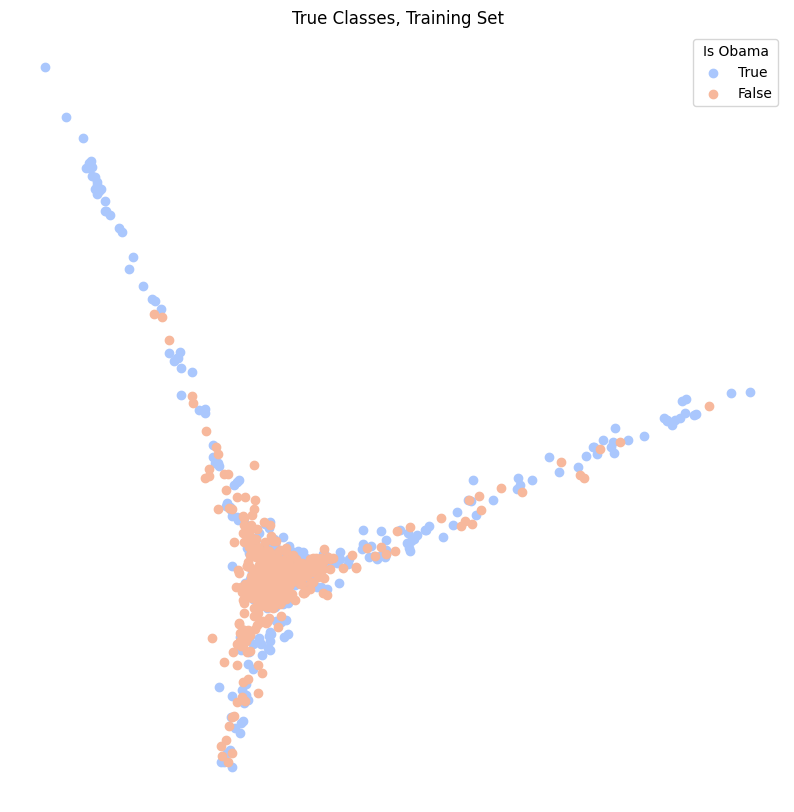

In [93]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

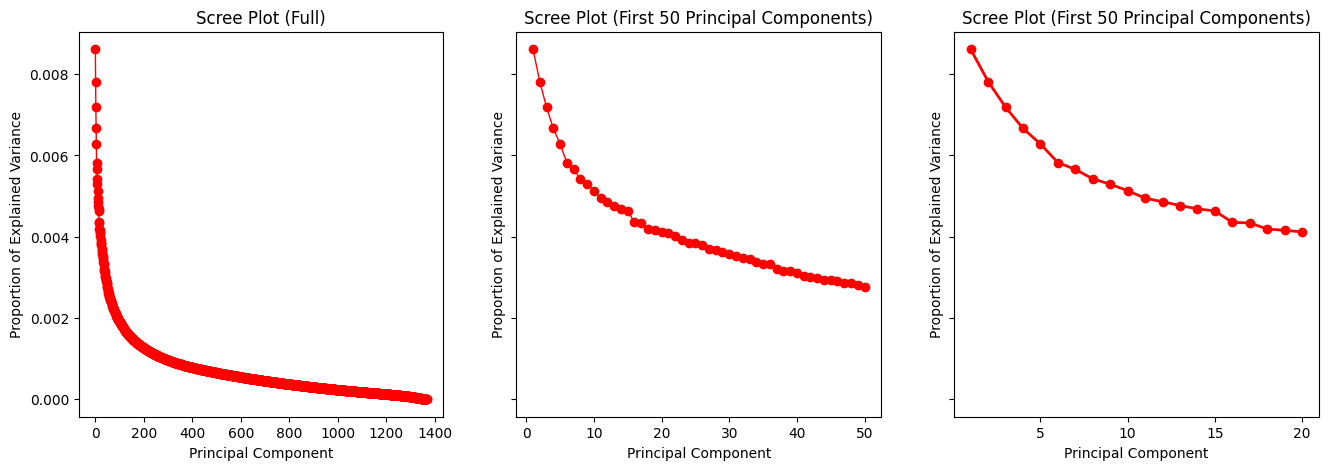

In [94]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [95]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [96]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [97]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6642282370153622

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [98]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6842105263157895

Slightly poorer. How about using more dimensions (40)?

In [99]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7432333577176299
Testing:
0.7339181286549707


Or still more (100)?

In [100]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8397951719092904
Testing:
0.7807017543859649


Or even more (200)!

In [101]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8814923189465984
Testing:
0.8011695906432749


This is becoming ridiculous (400)!

In [102]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9144111192392099
Testing:
0.8304093567251462


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [103]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.964155084125823


Train the model using training data, and then test it on the testing data.

In [104]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8538011695906432


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [105]:
import getpass
import time
import requests
import random
import pandas

In [106]:
api_key = getpass.getpass("Enter your API key: ")
headers = {"x-api-key": api_key}

Enter your API key: ··········


In [107]:
# Define the function to scrape abstract
def scrape_abstract(fieldsOfStudy, year, limit_per_field=600,
                    url='https://api.semanticscholar.org/graph/v1/paper/search'):

    headers = {"x-api-key": "KOyXiGdu4t38zFJFFyuKF5jQGBGdxCSfDICseepg"}

    all_data = []

    # Start with no offset
    offset = 0
    total_papers = 0

    while total_papers < limit_per_field:
        query_params = {
            'year': year,
            'query': fieldsOfStudy,
            'fields': 'title,authors,abstract',
            'limit': 100,  # This is typically the max the API allows per request
            'offset': offset
        }

        response = requests.get(url, headers=headers, params=query_params)

        if response.status_code == 200:
            papers = response.json().get('data', [])

            # Break the loop if no papers are returned
            if not papers:
                break

            for paper in papers:
                title = paper.get('title')
                author = paper.get('authors')
                abstract = paper.get('abstract')

                if not title or not author or not abstract:
                    continue

                author_names = ', '.join([a['name'] for a in author])

                all_data.append({
                    "Year": year,
                    "FieldOfStudy": fieldsOfStudy,
                    "Title": title,
                    "Author": author_names,
                    "Abstract": abstract})

                total_papers += 1

                # Break the loop if we have reached the limit
                if total_papers >= limit_per_field:
                    break

        else:
            print(f"Request failed with status code {response.status_code}")
            break

        # Increase the offset for the next loop iteration
        offset += len(papers)

        # Sleep to respect rate limits
        sleep_time = random.randint(1,3)
        time.sleep(sleep_time)

    df = pandas.DataFrame(all_data)

    return df

In [108]:
# Scrape psychology abstract from 2003 to 2023
fieldsOfStudy = ["Psychology", "History", "Biology"]

corpus = pandas.DataFrame()
for f in fieldsOfStudy:
    abstract = scrape_abstract(f, 2022)
    corpus = corpus.append(abstract, ignore_index = True)

corpus

Request failed with status code 400


,Year,FieldOfStudy,Title,Author,Abstract
0,2022,Psychology,Introduction to Industrial/organizational psyc...,R. Riggio,I. INTRODUCTION. 1. Introduction: Definitions ...
1,2022,Psychology,Using cognitive psychology to understand GPT-3,"Marcel Binz, Eric Schulz",Significance Language models are trained to pr...
2,2022,Psychology,Book review. The Cambridge Handbook of Persona...,M. Guseltseva,Research in personality psychology is making i...
3,2022,Psychology,Reconstructing Educational Psychology,B. Gillham,"Reconstructing educational psychology , Recons..."
4,2022,Psychology,Organizational Psychology in Cross Cultural Pe...,C. Silverthorne,Contents1 Introduction 2 Foundations of Organi...
...,...,...,...,...,...
1787,2022,Biology,pySBOL3: SBOL3 for Python Programmers.,"Tom Mitchell, Jacob Beal, Bryan A. Bartley",The Synthetic Biology Open Language version 3 ...
1788,2022,Biology,The changing influence of host genetics on the...,"Talia L. Karasov, D. Lundberg",Host genetics and the environment influence wh...
1789,2022,Biology,Use of Digital Whiteboard to Engage Undergradu...,"Aura Mendez, Juleissy Brioso, A. Jaramillo, Dh...",The development of critical thinking skills is...
1790,2022,Biology,The highways and byways of the brain,"C. Hilgetag, B. Zikopoulos",Brain functions rely on the communication netw...


In [109]:
corpus['tokenized_text'] = corpus['Abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
corpus['normalized_text'] = corpus['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Split the data into training data and testing data:

In [110]:
train_data_df, test_data_df = sklearn.model_selection.train_test_split(corpus, test_size=holdBackFraction)

Turn raw documents to a tf-idf matrix

In [111]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['Abstract'])

In [112]:
TFVects.shape

(1433, 8712)

Save TFVects in the dataframe:

In [113]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Do a dimension reduction to deal with the fact that we cannot have more variables than cases:

In [114]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [115]:
train_data_df['pca'] = [r for r in reduced_data]

Perform a screeplot to see how many Principal Components we need:

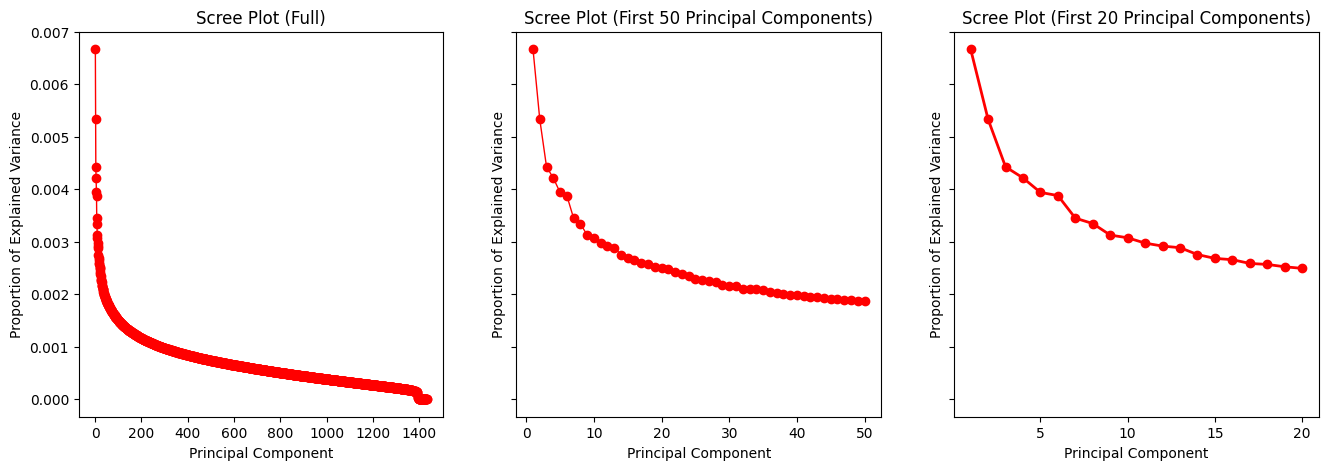

In [116]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Choose the first 10 pricipal components as our covariates.

In [117]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [118]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['FieldOfStudy'])

LogisticRegression()

In [119]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['FieldOfStudy'])

0.7780879274249826

Examine how it perform on the testing dataset:

In [120]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['Abstract'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['FieldOfStudy'])

0.7409470752089137

Using L1 regularization or L1-norm loss function to reduce overfitting (a model retaining only the most individually significant features):

In [121]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['FieldOfStudy'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['FieldOfStudy']))

0.9769713886950454


Train the model using training data, and then test it on the testing data.

In [122]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['FieldOfStudy']))

0.8356545961002786


Visualize the confusion matrix for training and testing sets (comparing logistic regression without regularization and the one with l1 regularization):

In [123]:
# Rename the "FieldOfStudy" column in test_data_df to "category" to fit in the functions
test_data_df.rename(columns={"FieldOfStudy": "category"}, inplace=True)

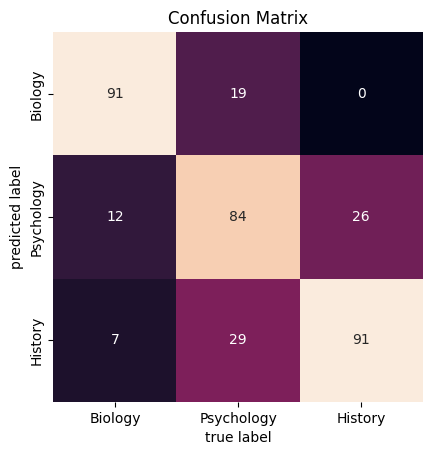

In [124]:
# Without regularization but with PCA reduced dimensions
def plotConfusionMatrix_updated(clf, testDF):
    predictions = clf.predict(np.stack(testDF['pca_reduced_10'], axis=0))
    mat = sklearn.metrics.confusion_matrix(testDF['category'], predictions)
    seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=testDF['category'].unique(), yticklabels=testDF['category'].unique())
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title("Confusion Matrix")
    plt.show()
    plt.close()

plotConfusionMatrix_updated(logistic, test_data_df)

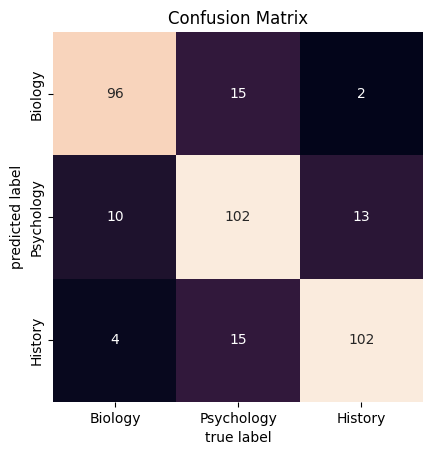

In [125]:
# With l1 regularization
lucem_illud.plotConfusionMatrix(logistic_l1, test_data_df)

 Calculate precision, recall, the F-measure, and AUC (comparing logistic regression without regularization but with PCA reduced dimensions and the one with l1 regularization):

In [126]:
# Without regularization but with PCA reduced dimensions
def evaluateClassifier_updated(clf, testDF):
    predictions = clf.predict(np.stack(testDF['pca_reduced_10'], axis=0))
    classes = []
    results = {
        'Error_Rate' : [],
        'AUC' : [],
        'Precision' : [],
        'Average_Precision' : [],
        'Recall' : [],
        }

    for cat in set(testDF['category']):
        preds = [True if (c == cat) else False for c in predictions]
        acts = [True if (c == cat) else False for c in testDF['category']]
        classes.append(cat)
        results['AUC'].append(sklearn.metrics.roc_auc_score(acts, preds))
        results['Average_Precision'].append(sklearn.metrics.average_precision_score(acts, preds))
        results['Precision'].append(sklearn.metrics.precision_score(acts, preds))
        results['Recall'].append(sklearn.metrics.recall_score(acts, preds))
        results['Error_Rate'].append(1 -  sklearn.metrics.accuracy_score(acts, preds))
    df = pandas.DataFrame(results, index=classes)
    df.index.rename('Category', inplace=True)
    return df

evaluateClassifier_updated(logistic, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Biology,0.105850,0.875484,0.827273,0.737305,0.827273
History,0.239554,0.734481,0.688525,0.571857,0.636364
Psychology,0.172702,0.814509,0.716535,0.629729,0.777778


In [127]:
# With l1 regularization
lucem_illud.evaluateClassifier(logistic_l1, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Biology,0.086351,0.902227,0.849558,0.780429,0.872727
History,0.147632,0.835703,0.816000,0.714111,0.772727
Psychology,0.094708,0.896641,0.842975,0.776684,0.871795


Perform an ROC visualization:

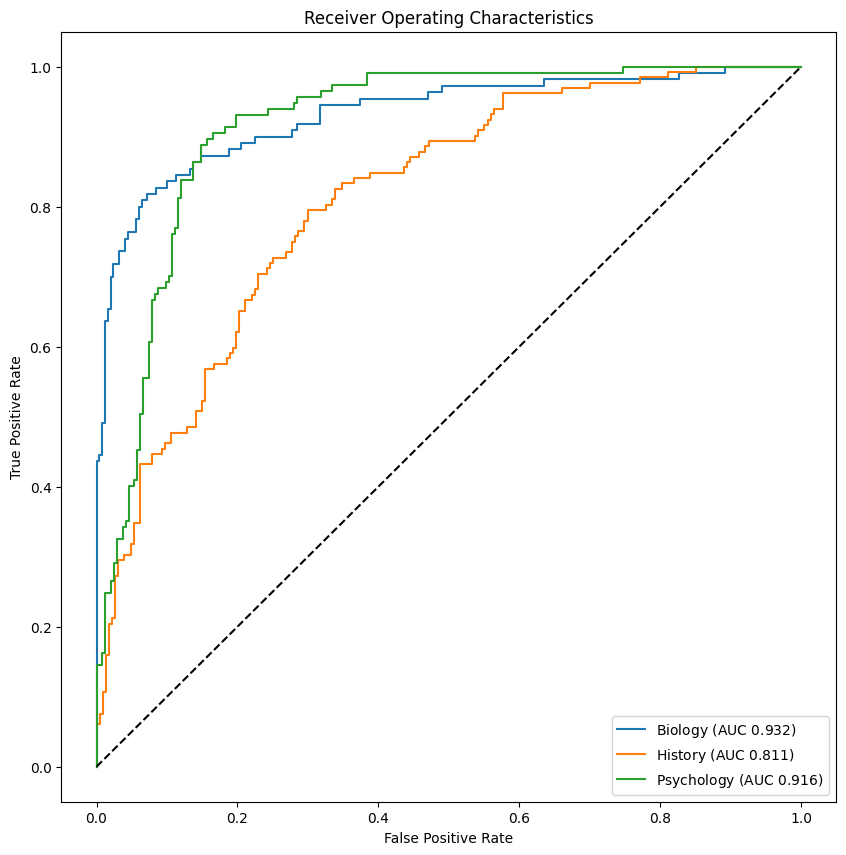

In [128]:
# Without regularization but with PCA reduced dimensions
def plotMultiROC_updated(clf, testDF):
    #By making the column names variables we can easily use this function on new data sets

    #Get the names of each of the possible classes and the probabiltiess
    classes = clf.classes_
    try:
        probs = clf.predict_proba(np.stack(testDF['pca_reduced_10'], axis=0))
    except AttributeError:
        print("The {} classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.".format(type(clf)))
        return
    predictions = clf.predict(np.stack(testDF['pca_reduced_10'], axis=0))

    #setup axis for plotting
    fig, ax = plt.subplots(figsize = (10,10))

    #We can return the AUC values, in case they are useful
    aucVals = []
    for classIndex, className in enumerate(classes):        #Setup binary classes
        truths = [1 if c == className else 0 for c in testDF['category']]
        predict = [1 if c == className else 0 for c in predictions]
        scores = probs[:, classIndex]

        #Get the ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(truths, scores)
        auc = sklearn.metrics.auc(fpr, tpr)
        aucVals.append(auc)

        #Plot the class's line
        ax.plot(fpr, tpr, label = "{} (AUC ${:.3f}$)".format(str(className).split(':')[0], auc))

    #Make the plot nice, then display it
    ax.set_title('Receiver Operating Characteristics')
    plt.plot([0,1], [0,1], color = 'k', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = 'lower right')
    plt.show()
    plt.close()

plotMultiROC_updated(logistic, test_data_df)


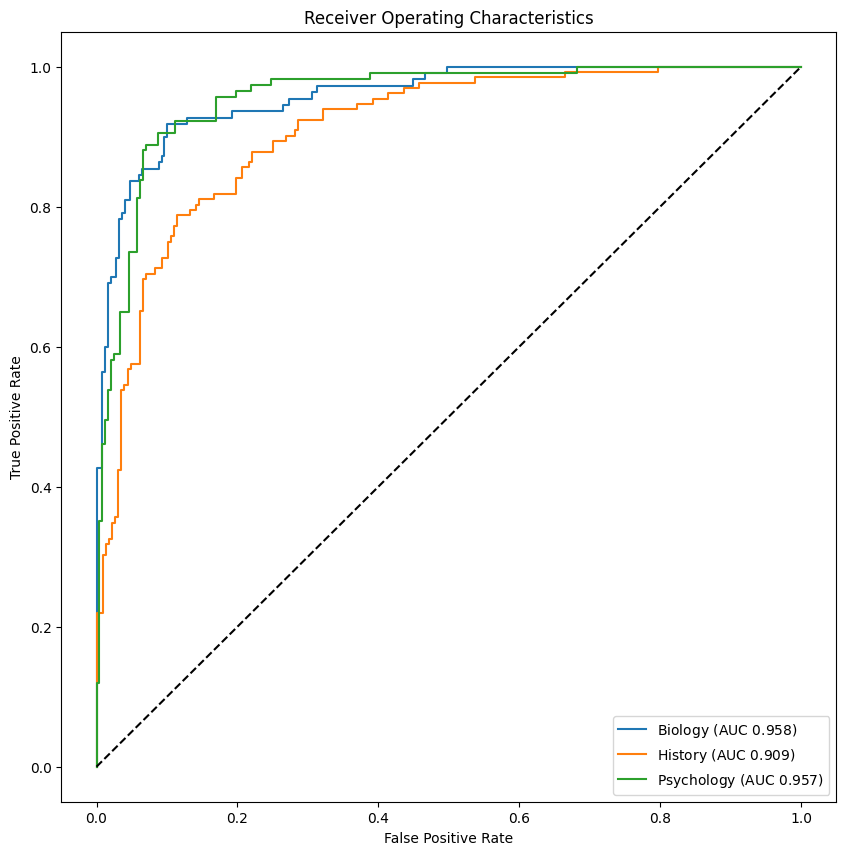

In [129]:
# With l1 regularization
lucem_illud.plotMultiROC(logistic_l1, test_data_df)

**Discussion**:

From the analysis above, we can see that logistic regression with l1 regularization performs better than logistic regression without regularization but with PCA reduced dimensions, as evidenced by the confusprecision, recall, the F-measure, and AUCion matrix.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

/usr/local/lib/python3.10/dist-packages/lucem_illud/cartoons.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)


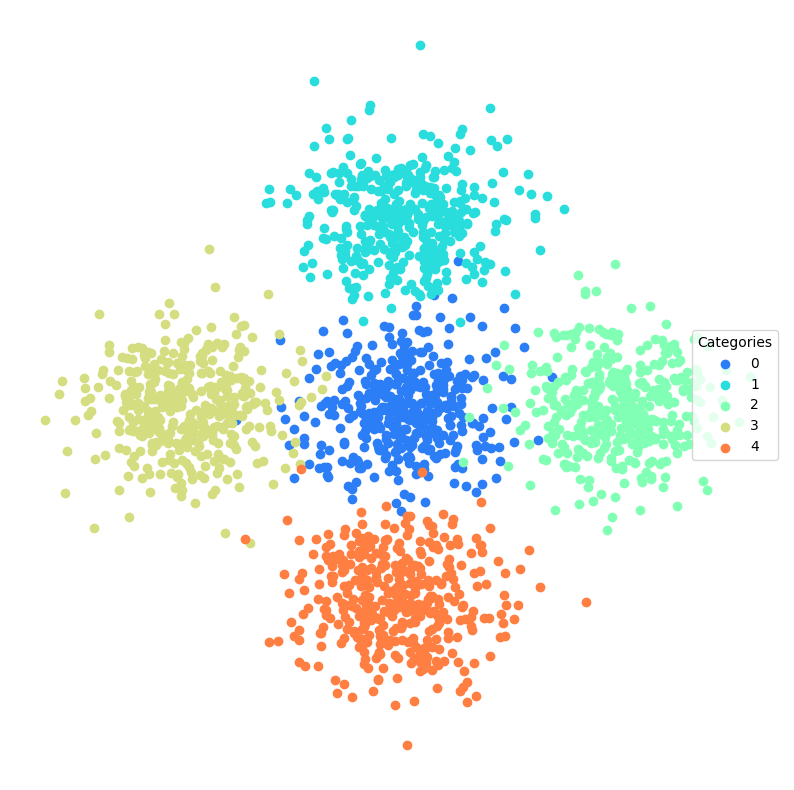

In [130]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [131]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification:

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


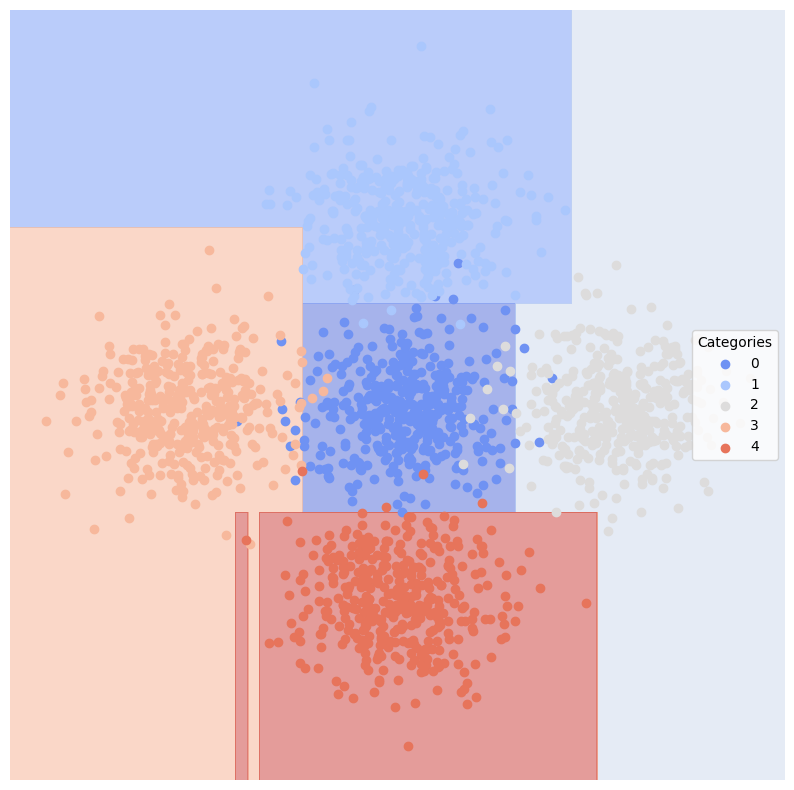

In [132]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [133]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.024,0.968022,0.914894,0.882232,0.955556
1,0.008,0.981982,1.000000,0.971964,0.963964
2,0.008,0.984177,0.990099,0.967261,0.970874
3,0.010,0.993827,0.950000,0.950000,1.000000
4,0.006,0.985149,1.000000,0.976297,0.970297


Lets look at accuracy:

In [134]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.972

What happens if we trim the tree?

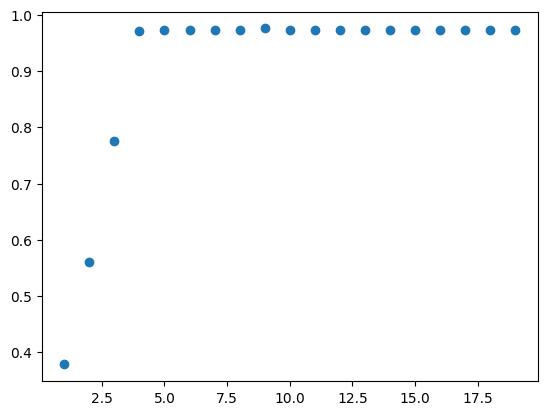

In [135]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [136]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [137]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


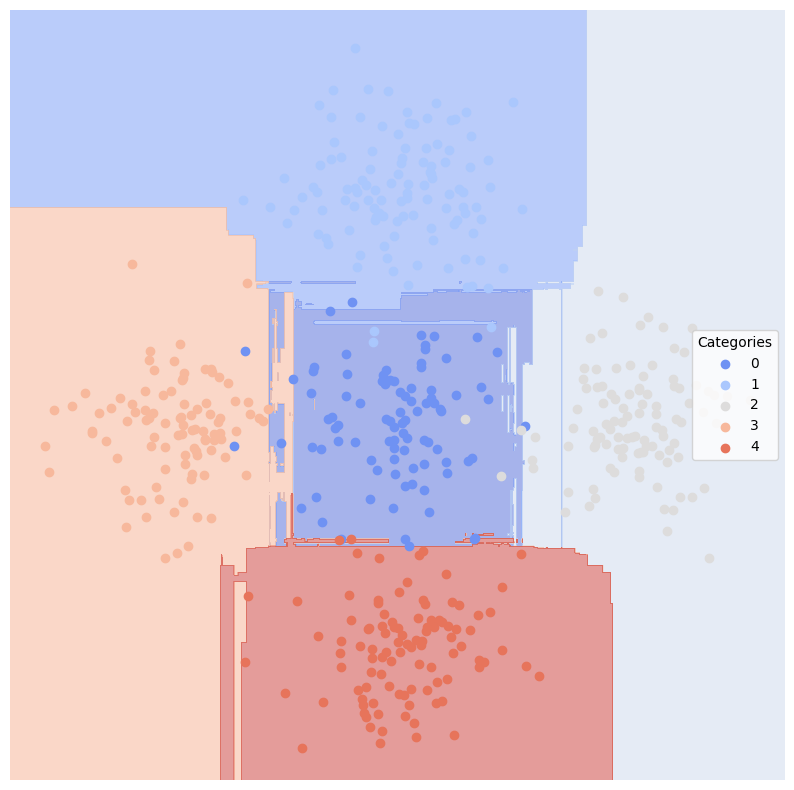

In [138]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [139]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.026,0.953794,0.932584,0.874050,0.922222
1,0.008,0.985201,0.990826,0.970047,0.972973
2,0.008,0.984177,0.990099,0.967261,0.970874
3,0.006,0.996296,0.969388,0.969388,1.000000
4,0.004,0.997494,0.980583,0.980583,1.000000


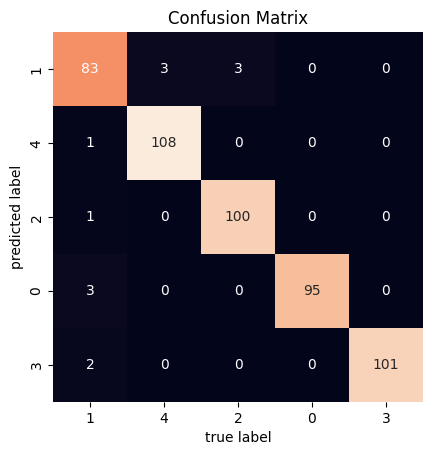

In [140]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

### Decision Tree Approach

In [141]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['FieldOfStudy'])

DecisionTreeClassifier(max_depth=4, random_state=0)

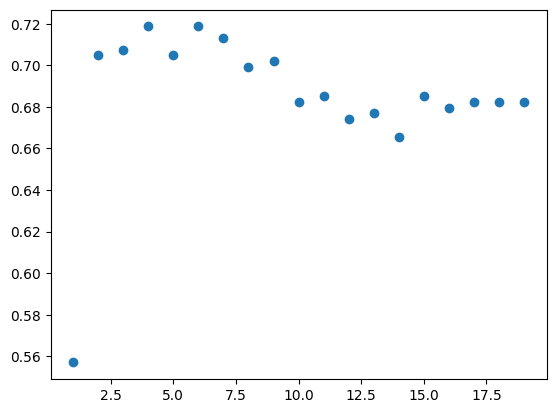

In [142]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['FieldOfStudy'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['pca_reduced_10'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [ ]:
def plotregions_updated(clf, df, h = .01):
    if np.random.choice(df['pca_reduced_10']).shape[0] > 2:
        pca = sklearn.decomposition.PCA(n_components = 2)
        reduced_data = pca.fit_transform(np.stack(df['pca_reduced_10'], axis=0))
        transformedDF = pandas.DataFrame({'vect' : [r for r in reduced_data], 'FieldOfStudy' : df['FieldOfStudy']})
    else:
        transformedDF = df
    catsMap = {c : i for i, c in enumerate(np.unique(df['FieldOfStudy']))}

    fig, ax = plt.subplots(figsize = (10,10))
    ax.axis('off')
    pallet = seaborn.color_palette(palette='coolwarm', n_colors = len(set(transformedDF['FieldOfStudy'])))

    if np.random.choice(df['pca_reduced_10']).shape[0] > 2:
        xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
                1.1 * reduced_data[:,0].max(), h),
            np.arange(1.1 * reduced_data[:,1].min(),
                1.1 * reduced_data[:,1].max(), h))
        Z = clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    else:
        reduced_data = np.stack(df['pca_reduced_10'], axis=0)
        xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
                1.1 * reduced_data[:,0].max(), h),
            np.arange(1.1 * reduced_data[:,1].min(),
                1.1 * reduced_data[:,1].max(), h))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.vectorize(lambda x: catsMap[x])(Z)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    for i, cat in enumerate(set(df['FieldOfStudy'])):
        a = np.stack(transformedDF[transformedDF['FieldOfStudy'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    plt.show()
    plt.close()

plotregions_updated(clf_tree, train_data_df)

In [ ]:
evaluateClassifier_updated(clf_tree, test_data_df)

In [ ]:
plotConfusionMatrix_updated(clf_tree, test_data_df)

### Random Forest Approach

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?